In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('deep')

df = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')
df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [2]:
df.drop('Id', axis=1, inplace=True)
id_array_test = df_test['Id'].values
df_test.drop('Id', axis=1, inplace=True)

### Outliers

By referring to the Ames Housing Dataset link provided in the Acknowledgements, you'll see that the author outlines there are some outliers that must be treated:

" Although all known errors were corrected in the data, no observations have been removed due to unusual values and all final residential sales from the initial data set are included in the data presented with this article. There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these points). Three of them are true outliers (Partial Sales that likely don’t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these five unusual observations) before assigning it to students. "

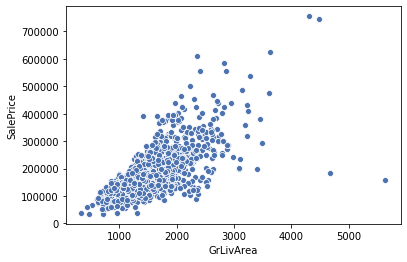

In [3]:
#Plot of SalePrice vs GrLivArea
ax = sns.scatterplot(y="SalePrice", x="GrLivArea", data=df)

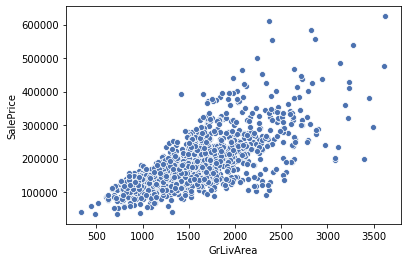

In [4]:
#Removing datapoints with GrLivArea greater than 4000 as they probably are outliers
df = df[df['GrLivArea'] < 4000]
ax = sns.scatterplot(y="SalePrice", x="GrLivArea", data=df)

In [5]:
#There is one more outlier which I found (accidentally) very late in the process and decided to include it here.
#There is a datapoint in which 'GarageYrBlt' has a value of 2207 which is not possible. So we'll replace the value
#with appropriate entry.
tmp = df_test[df_test['GarageYrBlt'] > 2010]
print (tmp)
idx = tmp.index
print (tmp['GarageType'])

#Since the GarageType is not Nan, this means the house has a garage. We'll replace the year by mode.
mode = (df_test['GarageYrBlt'].mode(dropna=True))[0]
df_test.iloc[1132, df_test.columns.get_loc('GarageYrBlt')] = mode

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1132          20       RL         68.0     8298   Pave   NaN      IR1   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
1132         HLS    AllPub    Inside  ...           0        0    NaN   NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
1132         NaN       0       9    2007       New        Partial  

[1 rows x 79 columns]
1132    Attchd
Name: GarageType, dtype: object


## Handling missing values

In [6]:
y_train = df['SalePrice'].values
df.drop('SalePrice', axis=1, inplace=True)

df_cum = pd.concat([df, df_test], ignore_index=True)

In [7]:
#We'll fill the columns which have 'NA' as a category in their description appropriately.
described_cols = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'MiscFeature', 'PoolQC']
df_cum[described_cols] = df_cum[described_cols].fillna('NA')

In [8]:
#Now we'll count the missing values in the remaining columns and plot a graph
from misc_functions import *
missing_val = np.array(get_na_count(df_cum))

[Text(0, 0, 'MSZoning'),
 Text(0, 0, 'LotFrontage'),
 Text(0, 0, 'Utilities'),
 Text(0, 0, 'Exterior1st'),
 Text(0, 0, 'Exterior2nd'),
 Text(0, 0, 'MasVnrType'),
 Text(0, 0, 'MasVnrArea'),
 Text(0, 0, 'BsmtFinSF1'),
 Text(0, 0, 'BsmtFinSF2'),
 Text(0, 0, 'BsmtUnfSF'),
 Text(0, 0, 'TotalBsmtSF'),
 Text(0, 0, 'Electrical'),
 Text(0, 0, 'BsmtFullBath'),
 Text(0, 0, 'BsmtHalfBath'),
 Text(0, 0, 'KitchenQual'),
 Text(0, 0, 'Functional'),
 Text(0, 0, 'GarageYrBlt'),
 Text(0, 0, 'GarageCars'),
 Text(0, 0, 'GarageArea'),
 Text(0, 0, 'SaleType')]

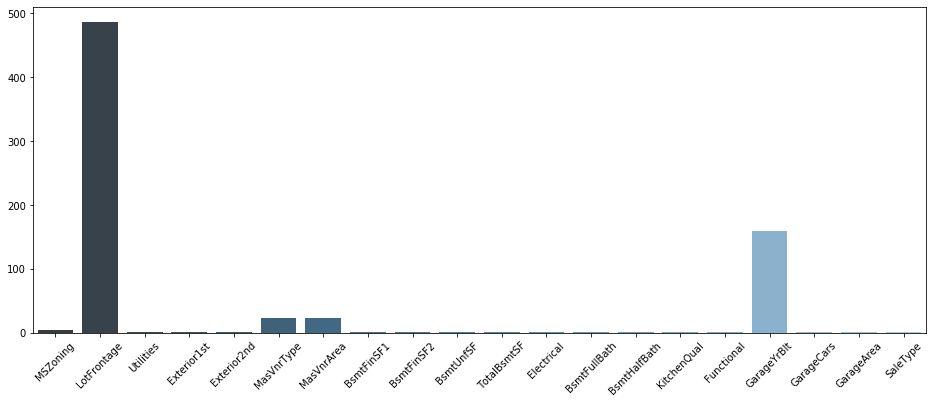

In [9]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x=missing_val[:,0], y=missing_val[:,1], palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

<ipython-input-10-455e9987d98b>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


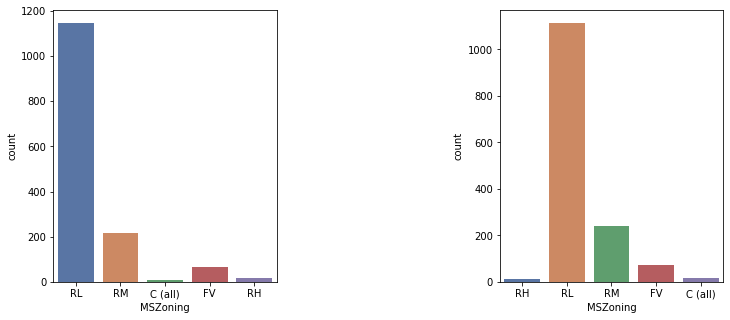

In [10]:
#MSZoning
fig, ax =fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.countplot(df['MSZoning'], ax=ax[0])
sns.countplot(df_test['MSZoning'], ax=ax[1])
plt.subplots_adjust(wspace=1)
fig.show()

In [11]:
#We can see that almost all the values in both test and train are 'RL'. We'll replace the missing vslues with it.
df_cum['MSZoning'] = df_cum['MSZoning'].fillna('RL')

60.0

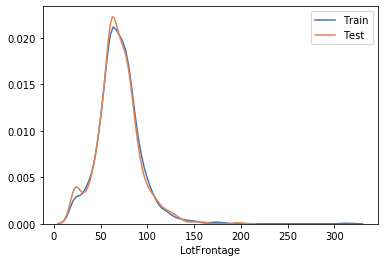

In [12]:
#Lot Frontage
sns.distplot(df['LotFrontage'], hist = False, kde = True, label='Train')
sns.distplot(df_test['LotFrontage'], hist = False, kde = True, label='Test')
df_cum['LotFrontage'].mode(dropna=True)[0]

In [13]:
#Looking at the distribution for both test and train (almost same) we can replace the missing values with the mode.
df_cum['LotFrontage'] = df_cum['LotFrontage'].fillna(df_cum['LotFrontage'].mode(dropna=True)[0])

<ipython-input-14-25c2c5bd4c3d>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


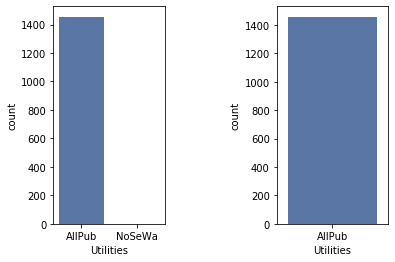

In [14]:
#Utilities
fig, ax =plt.subplots(1,2)
sns.countplot(df['Utilities'], ax=ax[0])
sns.countplot(df_test['Utilities'], ax=ax[1])
plt.subplots_adjust(wspace=1)
fig.show()

In [15]:
#We can see that the test data only has one category in utilities hence rendering it useless for the prediction. 
#We can drop this column.
df_cum.drop('Utilities', axis=1, inplace=True)

<ipython-input-16-0f13f1d76c1f>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


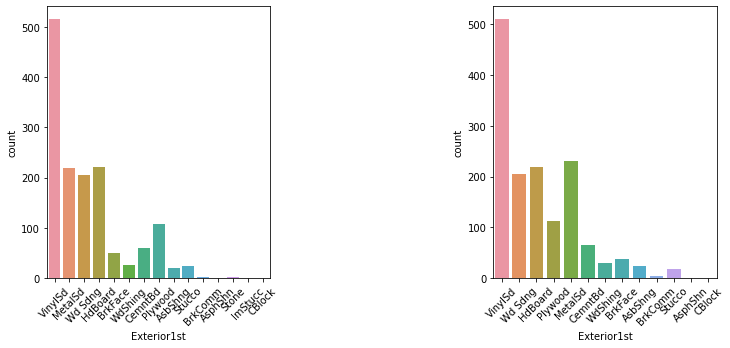

In [16]:
#Exterior1st
fig, ax =fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
a1 = sns.countplot(df['Exterior1st'], ax=ax[0])
a2 = sns.countplot(df_test['Exterior1st'], ax=ax[1])
plt.subplots_adjust(wspace=1)
a1.set_xticklabels(a1.get_xticklabels(), rotation=45)
a2.set_xticklabels(a2.get_xticklabels(), rotation=45)
fig.show()

In [17]:
#We'll go with the most popular Exterior1st as it is consistent in both test and train.
df_cum['Exterior1st'] = df_cum['Exterior1st'].fillna(df_cum['Exterior1st'].mode(dropna=True)[0])
df_cum['Exterior2nd'] = df_cum['Exterior2nd'].fillna(df_cum['Exterior2nd'].mode(dropna=True)[0])
df_cum['MasVnrType'] = df_cum['MasVnrType'].fillna(df_cum['MasVnrType'].mode(dropna=True)[0])
df_cum['MasVnrArea'] = df_cum['MasVnrArea'].fillna(df_cum['MasVnrArea'].mode(dropna=True)[0])
df_cum['Electrical'] = df_cum['Electrical'].fillna(df_cum['Electrical'].mode(dropna=True)[0])
df_cum['KitchenQual'] = df_cum['KitchenQual'].fillna(df_cum['KitchenQual'].mode(dropna=True)[0])
df_cum['Functional'] = df_cum['Functional'].fillna(df_cum['Functional'].mode(dropna=True)[0])
df_cum['GarageCars'] = df_cum['GarageCars'].fillna(df_cum['GarageCars'].mode(dropna=True)[0])
df_cum['GarageArea'] = df_cum['GarageArea'].fillna(df_cum['GarageArea'].mean())
df_cum['SaleType'] = df_cum['SaleType'].fillna(df_cum['SaleType'].mode(dropna=True)[0])

In [18]:
#For BsmtFinSF1 we observed the only datapoint for which the value was missing had BsmtFinType1 as NA i.e 
#there is no basement. So we can fill the SF as 0
df_cum['BsmtFinSF1'] = df_cum['BsmtFinSF1'].fillna(0)
#Same goes for BsmtFinSF2
df_cum['BsmtFinSF2'] = df_cum['BsmtFinSF2'].fillna(0)
#Same data point is valid for BsmtUnfSF and TotalBsmtSF. We can fill them all with zeros.
df_cum['BsmtUnfSF'] = df_cum['BsmtUnfSF'].fillna(0)
df_cum['TotalBsmtSF'] = df_cum['TotalBsmtSF'].fillna(0)

2116    0.0
2184    0.0
Name: TotalBsmtSF, dtype: float64


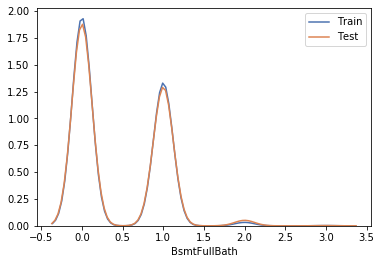

In [19]:
#BsmtFullBath
var = 'BsmtFullBath'
sns.distplot(df[var], hist = False, kde = True, label='Train')
sns.distplot(df_test[var], hist = False, kde = True, label='Test')
tmp = df_cum[df_cum[var].isnull()]
print (tmp['TotalBsmtSF'])

#We observe that the total bsmt area is zero for both the datapoints so we can replace the nan with 0
df_cum['BsmtFullBath'] = df_cum['BsmtFullBath'].fillna(0)
#Same goes for BsmtHalfBath
df_cum['BsmtHalfBath'] = df_cum['BsmtHalfBath'].fillna(0)

In [20]:
#GarageYrBlt
#For the datapoints where GarageYrBlt is Nan, we check whether GarageType is NA or not. NA means the house has no
#garage and we can keep it as '0'. As we will convert all the year columns to categorical using '0' will not be an 
#issue. For the rest of the datapoints we will replace Nan with the mode.
mode = (df_cum['GarageYrBlt'].mode(dropna=True))[0]
for index, row in df_cum.iterrows():
    if np.isnan(row['GarageYrBlt']):
        if row['GarageType'] == 'NA':
            df_cum.iloc[index, df_cum.columns.get_loc('GarageYrBlt')] = 0.0
        else:
            df_cum.iloc[index, df_cum.columns.get_loc('GarageYrBlt')] = mode

## Feature Engineering

We'll go one by one over all the features and apply the pertaining techniques on them to extract more information from our dataset. We'll drop the unnecessary features to make our data dense in terms of the info it provides. We'll also transform the features as per the needs. All this analysis will be done by visualising the trends in each feature using graphs. 

### Polynomial fit

Let's first get the correlation matrix and figure out which features have the most influence on the SalePrice so that we could extract more info from them

In [21]:
df_train = df_cum[:1456].copy()
df_test = df_cum[1456:].copy()
df_train['SalePrice'] = y_train
df_train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave    NA      Reg   
1          20       RL         80.0     9600   Pave    NA      Reg   
2          60       RL         68.0    11250   Pave    NA      IR1   
3          70       RL         60.0     9550   Pave    NA      IR1   
4          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour LotConfig LandSlope  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    Inside       Gtl  ...        0     NA    NA          NA   
1         Lvl       FR2       Gtl  ...        0     NA    NA          NA   
2         Lvl    Inside       Gtl  ...        0     NA    NA          NA   
3         Lvl    Corner       Gtl  ...        0     NA    NA          NA   
4         Lvl       FR2       Gtl  ...        0     NA    NA          NA   

  MiscVal  MoSold  YrSold  SaleType  SaleCondition SalePrice  
0       0       2    2008        WD         Normal    208500  
1       0       5    2007        WD         Normal    181500  
2       0       9    2008        WD         Normal    223500  
3       0       2    2006        WD        Abnorml    140000  
4       0      12    2008        WD         Normal    250000  

[5 rows x 79 columns]

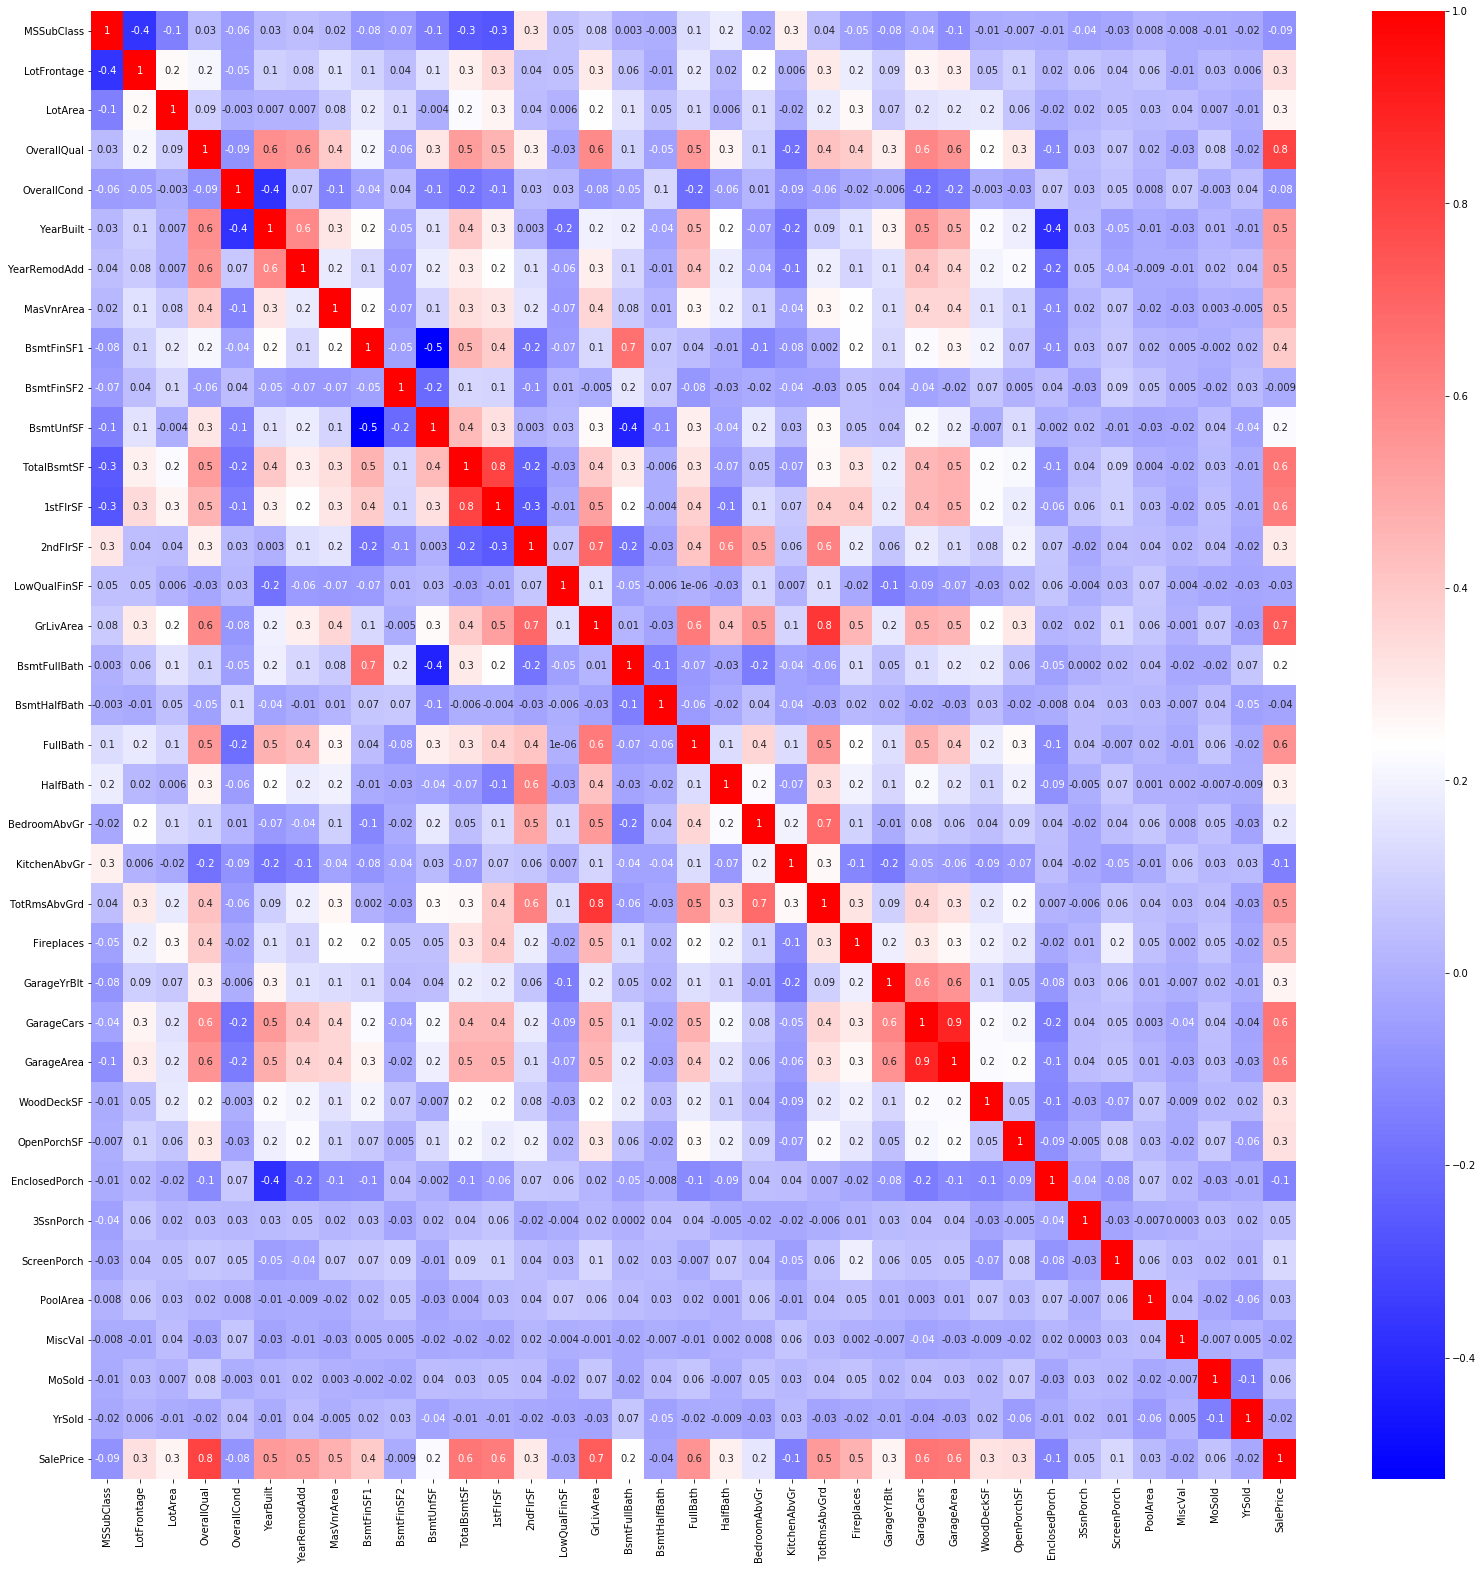

In [22]:
plt.figure(figsize=(27, 27))
sns.heatmap(df_train.corr(), annot = True, fmt='.1g', cmap='bwr')

Here is a list of features which have relatively higher impact on the Sales Price:

* OverallQual
* YearBuilt
* YearRemodAdd
* MasVnrArea
* TotalBsmtSF
* 1stFlrSF
* GrLivArea
* FullBath
* TotRmsAbvGrd
* Fireplaces
* GarageCars
* GarageArea

We'll form polynomials of these features so that more info on the correlation with Sales Price could be extracted.

In [23]:
poly_cols = ['OverallQual',
'MasVnrArea',
'TotalBsmtSF',
'1stFlrSF',
'GrLivArea',
'FullBath',
'TotRmsAbvGrd',
'Fireplaces',
'GarageCars',
'GarageArea',
'BsmtFinSF1',]

In [24]:
#Square
for col in poly_cols:
    df_cum[col + '_square'] = df_cum[col]**2

#Cube
for col in poly_cols:
    df_cum[col + '_cube'] = df_cum[col]**3

#Square root
for col in poly_cols:
    df_cum[col + '_sqrt'] = df_cum[col]**0.5
df_cum

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0             60       RL         65.0     8450   Pave    NA      Reg   
1             20       RL         80.0     9600   Pave    NA      Reg   
2             60       RL         68.0    11250   Pave    NA      IR1   
3             70       RL         60.0     9550   Pave    NA      IR1   
4             60       RL         84.0    14260   Pave    NA      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2910         160       RM         21.0     1936   Pave    NA      Reg   
2911         160       RM         21.0     1894   Pave    NA      Reg   
2912          20       RL        160.0    20000   Pave    NA      Reg   
2913          85       RL         62.0    10441   Pave    NA      Reg   
2914          60       RL         74.0     9627   Pave    NA      Reg   

     LandContour LotConfig LandSlope  ... MasVnrArea_sqrt TotalBsmtSF_sqrt  \
0            Lvl    Inside       Gtl  ...       14.000000        29.257478   
1            Lvl       FR2       Gtl  ...        0.000000        35.524639   
2            Lvl    Inside       Gtl  ...       12.727922        30.331502   
3            Lvl    Corner       Gtl  ...        0.000000        27.495454   
4            Lvl       FR2       Gtl  ...       18.708287        33.837849   
...          ...       ...       ...  ...             ...              ...   
2910         Lvl    Inside       Gtl  ...        0.000000        23.366643   
2911         Lvl    Inside       Gtl  ...        0.000000        23.366643   
2912         Lvl    Inside       Gtl  ...        0.000000        34.985711   
2913         Lvl    Inside       Gtl  ...        0.000000        30.199338   
2914         Lvl    Inside       Mod  ...        9.695360        31.559468   

     1stFlrSF_sqrt GrLivArea_sqrt FullBath_sqrt  TotRmsAbvGrd_sqrt  \
0        29.257478      41.352146      1.414214           2.828427   
1        35.524639      35.524639      1.414214           2.449490   
2        30.331502      42.261093      1.414214           2.449490   
3        31.000000      41.436699      1.000000           2.645751   
4        33.837849      46.882833      1.414214           3.000000   
...            ...            ...           ...                ...   
2910     23.366643      33.045423      1.000000           2.236068   
2911     23.366643      33.045423      1.000000           2.449490   
2912     34.985711      34.985711      1.000000           2.645751   
2913     31.144823      31.144823      1.000000           2.449490   
2914     31.559468      44.721360      1.414214           3.000000   

      Fireplaces_sqrt  GarageCars_sqrt  GarageArea_sqrt BsmtFinSF1_sqrt  
0                 0.0         1.414214        23.409400       26.570661  
1                 1.0         1.414214        21.447611       31.272992  
2                 1.0         1.414214        24.657656       22.045408  
3                 1.0         1.732051        25.337719       14.696938  
4                 1.0         1.732051        28.913665       25.592968  
...               ...              ...              ...             ...  
2910              0.0         0.000000         0.000000        0.000000  
2911              0.0         1.000000        16.911535       15.874508  
2912              1.0         1.414214        24.000000       34.985711  
2913              0.0         0.000000         0.000000       18.357560  
2914              1.0         1.732051        25.495098       27.531800  

[2915 rows x 111 columns]

### Analysing each feature

We'll go through each feature and apply the relevant transformations.

#### 1. Exterior features 

##### LotFrontage (Linear feet of street connected to property)

In [25]:
df_train['LotFrontage'].describe()

count    1456.000000
mean       67.969093
std        21.228452
min        21.000000
25%        60.000000
50%        63.000000
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

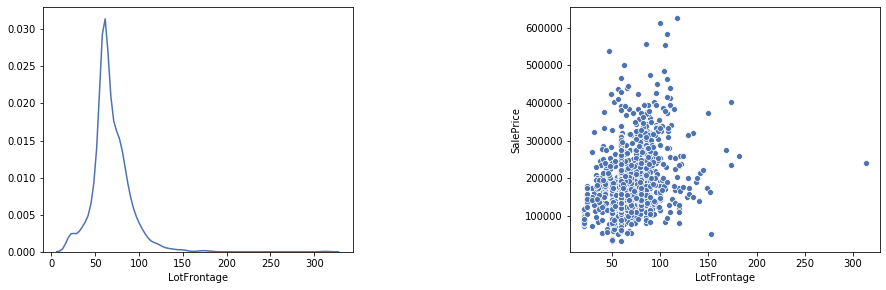

In [26]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train['LotFrontage'], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x="LotFrontage", data=df_train, ax=ax[1])

* There seems to be no correlation between SalePrice and LotFrontage.
* The distribution is positvely skewed. We'll take a log to make the distribution more normal.

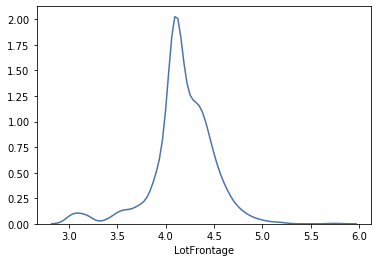

In [27]:
df_cum['LotFrontage'] = np.log(df_cum['LotFrontage'])
#Not so skewed distribution.
sns.distplot(np.log(df_train['LotFrontage']), hist = False, kde = True)

##### Lot Area (Lot size in square feet)

In [28]:
df_train['LotArea'].describe()

count      1456.000000
mean      10448.784341
std        9860.763449
min        1300.000000
25%        7538.750000
50%        9468.500000
75%       11588.000000
max      215245.000000
Name: LotArea, dtype: float64

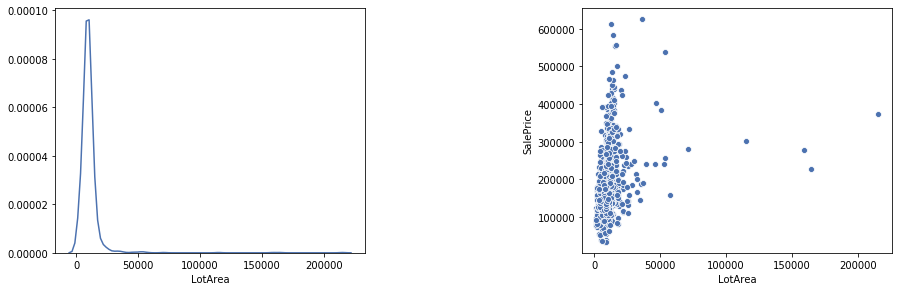

In [29]:
var = 'LotArea'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

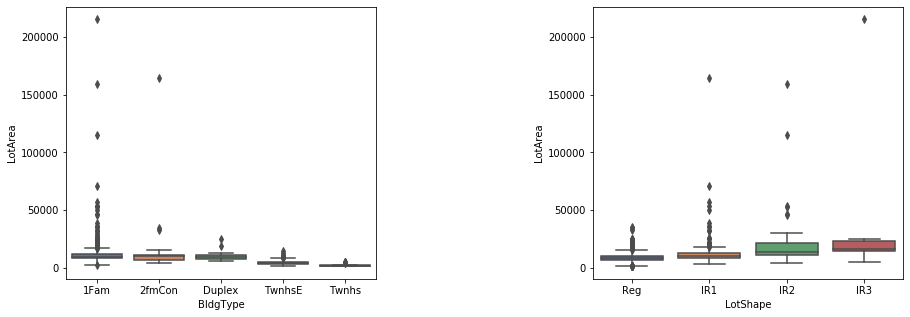

In [30]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)
sns.boxplot(x='BldgType', y='LotArea', data=df_train, ax=ax[0])
sns.boxplot(x='LotShape', y='LotArea', data=df_train, ax=ax[1])

* LotArea depends upon LotShape and BldgType.
* It has almost no correlation with the SalePrice.
* Since it is highly skewed (positive), we'll apply the log transformation to make it more normal.

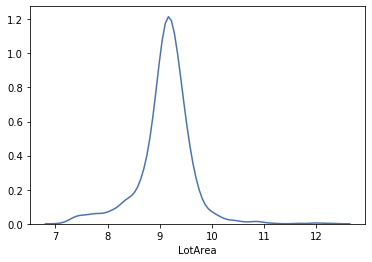

In [31]:
df_cum[var] = np.log(df_cum[var])
sns.distplot(np.log(df_train[var]), hist = False, kde = True)

##### Street (Type of road access to property)

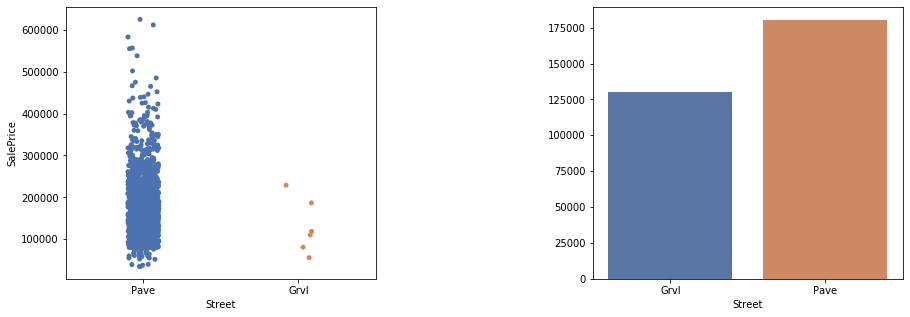

In [32]:
var = 'Street'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* The average SalePrice is higher for Pave. Also, there are very less houses which have Grvl streets.
* We'll see what is the trend in test data.

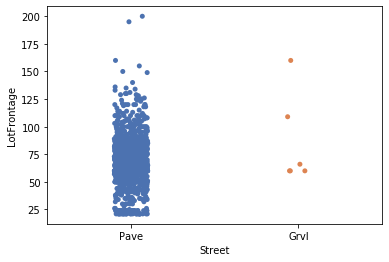

In [33]:
sns.stripplot(x=var, y='LotFrontage', data=df_test)

* Even in test data almost all houses have Pave street so we'll drop this feature as it doesn't contribute much to the SalePrice.

In [34]:
df_cum.drop('Street', axis=1, inplace=True)

##### Alley (Type of alley access to property)

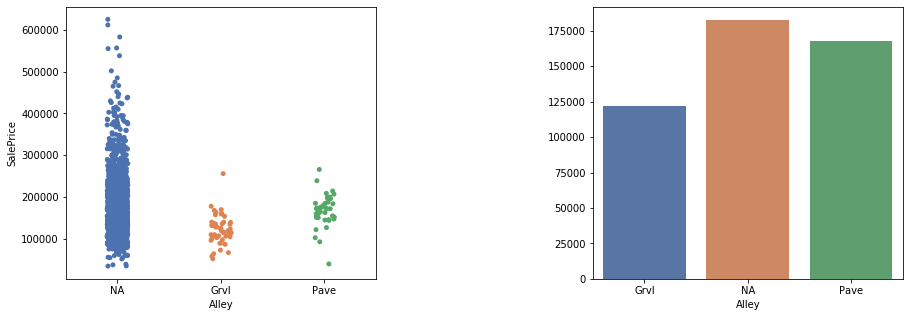

In [35]:
var = 'Alley'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Both Grvl and Pave has almost equal number of datapoints and Pave has a higher average SalePrice. This feature could be a could contributor in predicting the price.
* We'll create dummy variables for the categories.

In [36]:
df_cum = pd.get_dummies(df_cum, columns=['Alley'])

###### Neighborhood (Physical locations within Ames city limits)

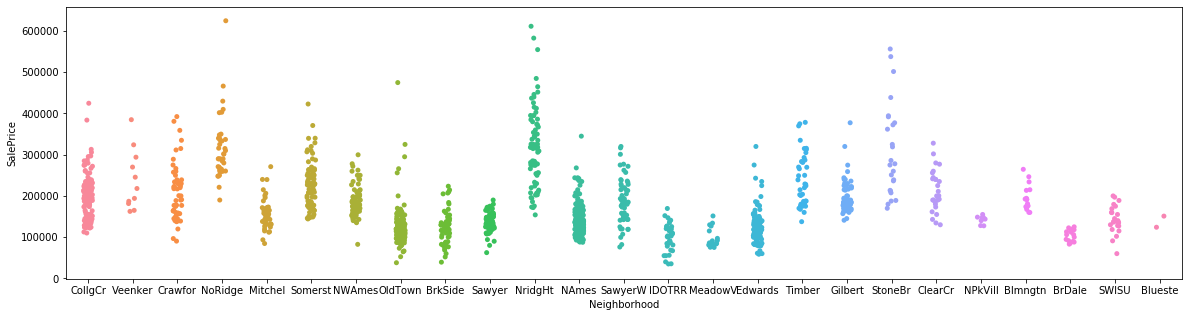

In [37]:
var = 'Neighborhood'
mean = df_train.groupby(var).mean()['SalePrice']
plt.figure(figsize=(20, 5))
sns.stripplot(x=var, y='SalePrice', data=df_train)

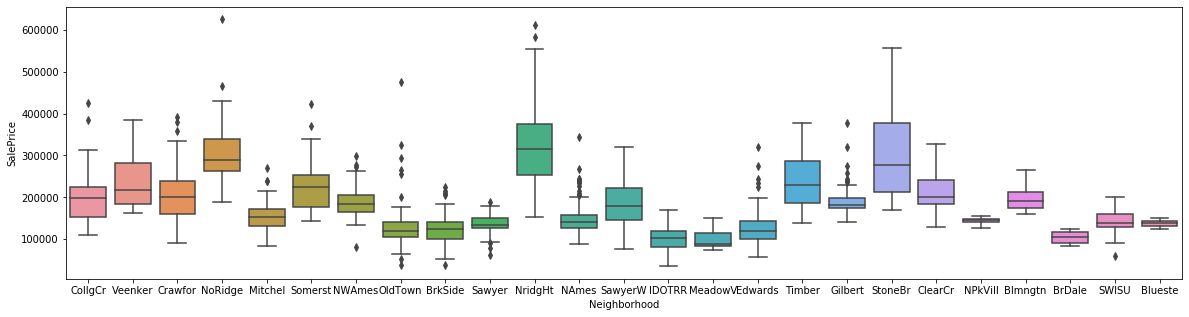

In [38]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)

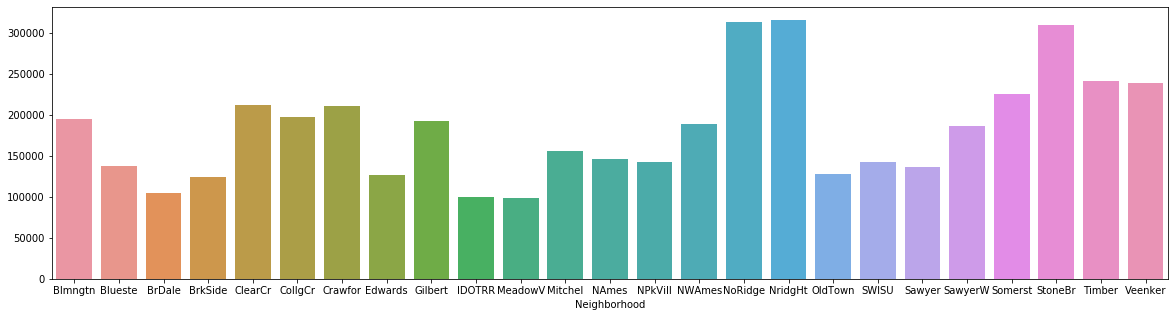

In [39]:
plt.figure(figsize=(20, 5))
sns.barplot(x=mean.keys(), y=mean.to_numpy())

* We can see that the neighborhood of the house has a significant impact on the SalePrice. The average price is an indicator of the penchant towards those neighborhood.
* This feature also could be a good indicator of the price of the house.
* We'll create a dummy variabe for each category.

In [40]:
df_cum = pd.get_dummies(df_cum, columns=['Neighborhood'])

###### Condition1 and Condition 2 (Proximity to various conditions)

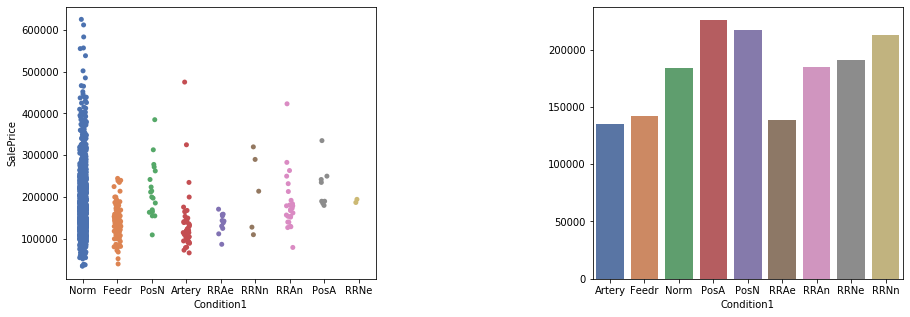

In [41]:
var = 'Condition1'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

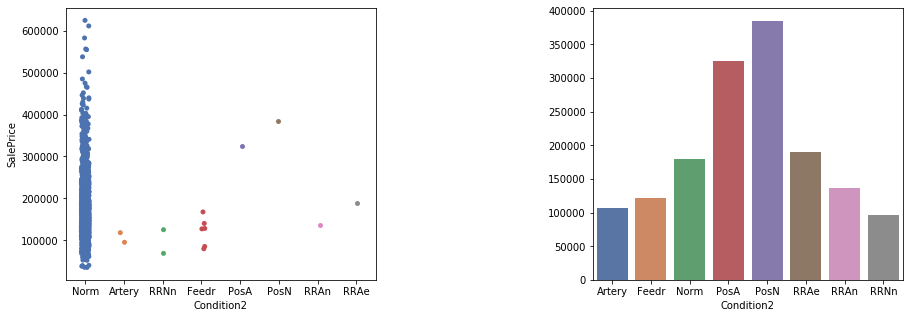

In [42]:
var = 'Condition2'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* As expected, houses which have features like a greenbelt or a park in theor proximity have higher SalePrice.
* There are a very few houses which have 2 features in their proximity. Condition2 is mostly Norm which means normal. 
* Same trend is seen with Condition2, if at all it is present. PosA and PosN have higher average prices but their count is very low.
* We'll create dummy variabes for each category in Condition1.
* But we'll group the positive and negative fearures in Condition2. We can also drop Condition2 and replace it with a flag but let's not lose on any information, even if it's small.

In [43]:
df_cum = pd.get_dummies(df_cum, columns=['Condition1'])

In [44]:
df_cum['Cond2_pos'] = (df_cum['Condition2'] == 'PosA') | (df_cum['Condition2'] == 'PosB').astype(int)
df_cum['Cond2_norm'] = (df_cum['Condition2'] == 'Norm').astype(int)
df_cum['Cond2_neg'] = ((df_cum['Condition2'] == 'Artery') | (df_cum['Condition2'] == 'Feedr') | (df_cum['Condition2'] == 'RRAe') | (df_cum['Condition2'] == 'RRAn') | (df_cum['Condition2'] == 'RRNn')).astype(int)
df_cum.drop('Condition2', axis=1, inplace=True)

##### RoofMatl (Roof material)

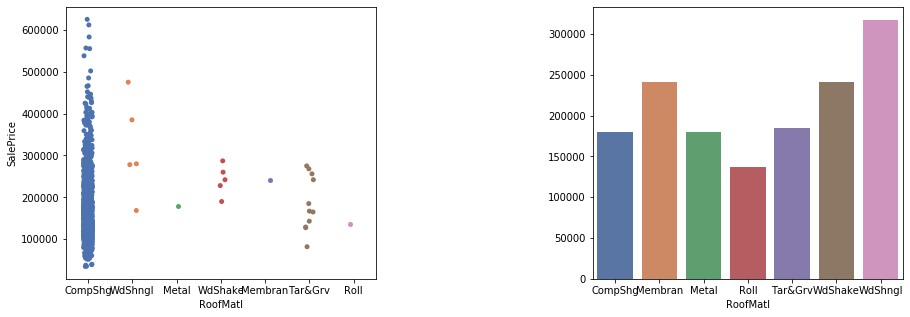

In [45]:
var = 'RoofMatl'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* The price for roof with wooden work is higher while most of the houses have the standard shingle.
* Even though some of the categories do not have much observations, we'll create dummy for each one of them.

In [46]:
df_cum = pd.get_dummies(df_cum, columns=['RoofMatl'])

###### Exterior1st and Exterior2nd (Exterior covering on house)

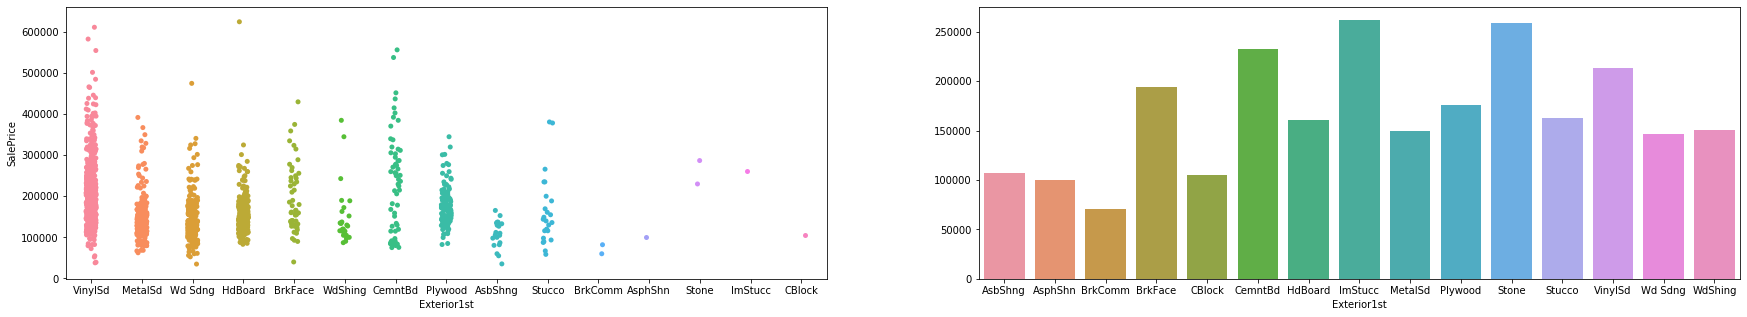

In [47]:
var = 'Exterior1st'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(30,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

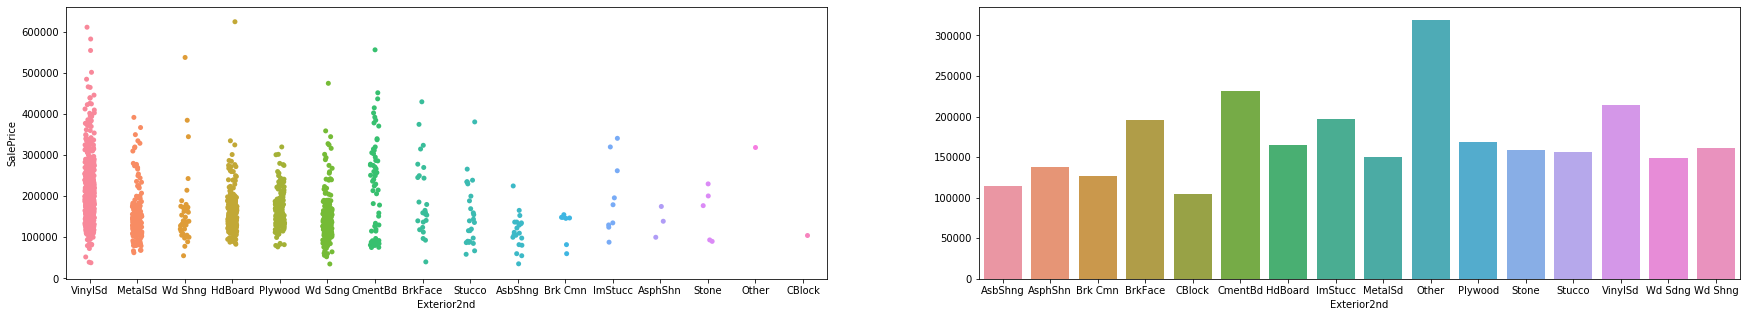

In [48]:
var = 'Exterior2nd'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(30,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

In [49]:
#No of houses having same 1st and 2nd coverings out of 2915 houses
sum((df_cum['Exterior1st'] == df_cum['Exterior2nd']))

2480

* Both the exterior coverings show nearly the same behaviour when it comes to their effect on SalePrice. 
* It might seem redundant to keep both the features.
* We'll create dummy variables for 1st and drop 2nd with a flag stating whether 1st is equal to 2nd.

In [50]:
df_cum['Ext1st_eq_2nd'] = (df_cum['Exterior1st'] == df_cum['Exterior2nd']).astype(int)
df_cum = pd.get_dummies(df_cum, columns=['Exterior1st'])
df_cum.drop('Exterior2nd', axis=1, inplace=True)

###### MasVnrType (Masonry veneer type)

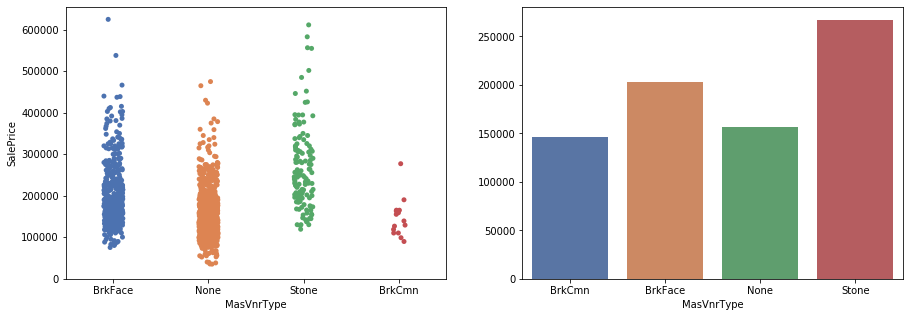

In [51]:
var = 'MasVnrType'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Each category has its own range of prices.
* We'll create dummy variables for each of them.

In [52]:
df_cum = pd.get_dummies(df_cum, columns=['MasVnrType'])

###### MasVnrArea (Masonry veneer area in square feet)

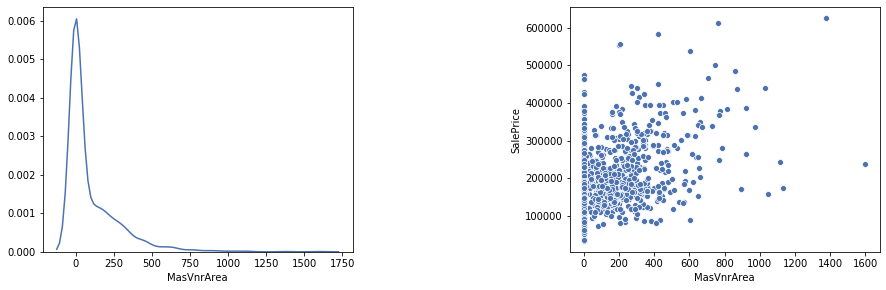

In [53]:
var = 'MasVnrArea'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

In [54]:
df_train['SalePrice'].corr(df_train['MasVnrArea'], method='pearson')

0.4736503938607982

* From the correlation matrix we can see that there is some info in this variable.
* It might be redundant to keep this feature as it is 0 when MasVnrType is None, which is very frequent.
* But we'll not miss out on any data and keep it.
* It is highly positive skewed but we can't take a log due to it being 0 in many cases.


###### ExterQual (Evaluates the quality of the material on the exterior) 

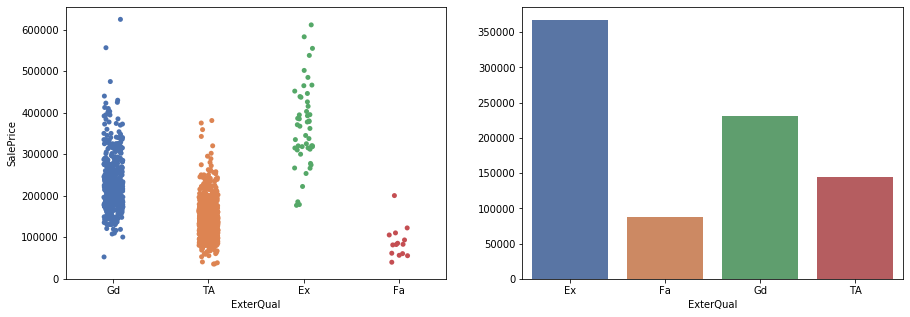

In [55]:
var = 'ExterQual'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* As expected, the sale price depends upon the quality and increases as the quality becomes better.
* This will be a very important feature and since it is clearly ordered, we'll replace the variables with [1,2,3,4]
* Po (Poor) variable is not used in either test ot train data.

In [56]:
df_cum['ExterQual'] = df_cum['ExterQual'].replace({'Ex':4, 'Gd':3, 'TA':2, 'Fa':1})

###### ExterCond: Evaluates the present condition of the material on the exterior

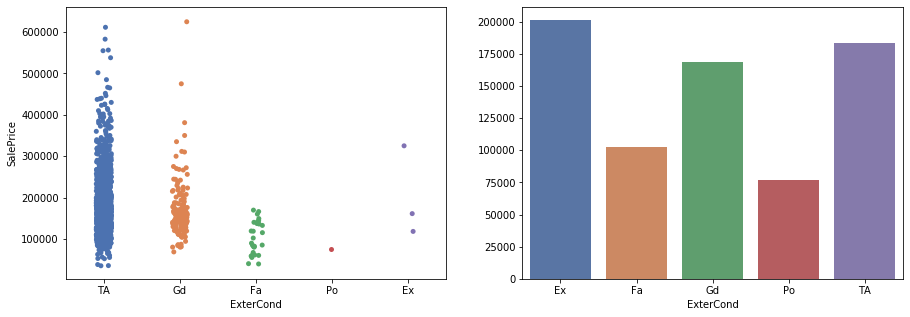

In [57]:
var = 'ExterCond'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* This feature have similar trend as ExterQual but may not be ordered.
* We'll create dummy variables.

In [58]:
df_cum = pd.get_dummies(df_cum, columns=['ExterCond'])

###### PavedDrive (Paved driveway)

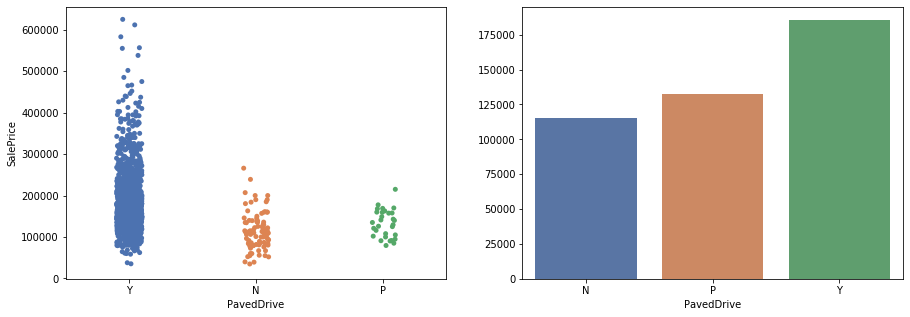

In [59]:
var = 'PavedDrive'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* As expected the paved driveway has higher average price as compared to partially paved and un-paved.
* We'll create dummy variables for all 3.

In [60]:
df_cum = pd.get_dummies(df_cum, columns=['PavedDrive'])

###### WoodDeckSF (Wood deck area in square feet)

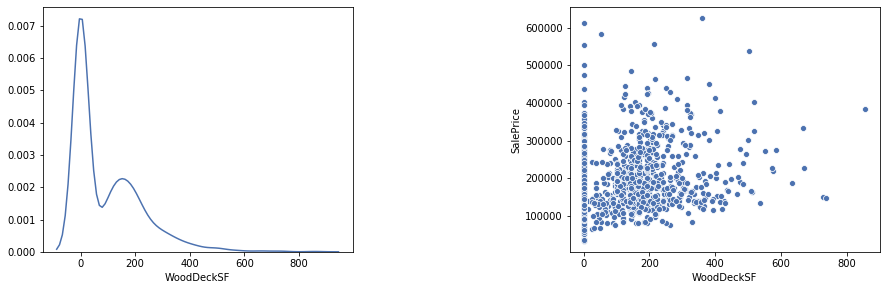

In [61]:
var = 'WoodDeckSF'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

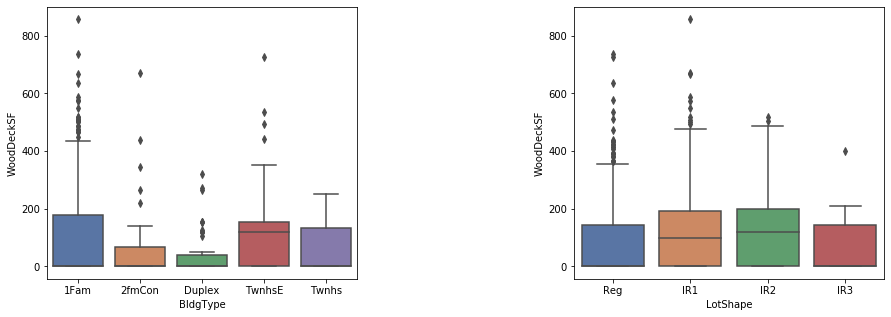

In [62]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)
sns.boxplot(x='BldgType', y=var, data=df_train, ax=ax[0])
sns.boxplot(x='LotShape', y=var, data=df_train, ax=ax[1])

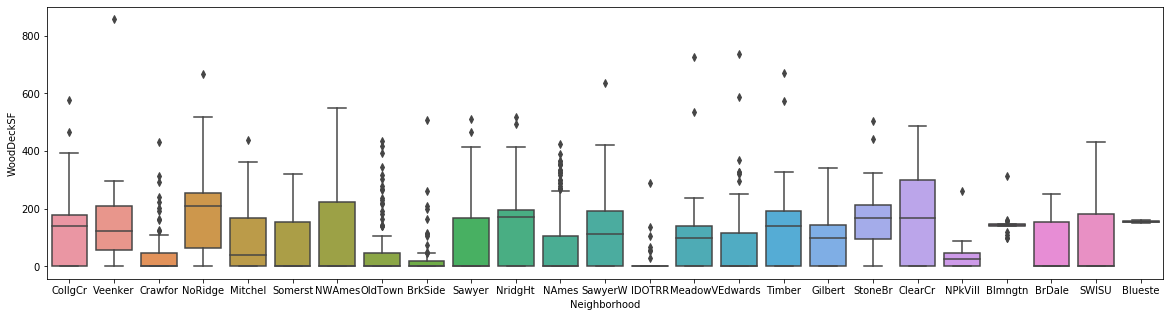

In [63]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='Neighborhood', y=var, data=df_train)

* It has a correlation og 0.3 with the SalePrice and depends heavily in the BldgType and Neighborhood.
* This could be an important feature and so we'll bin it (since the distribution is not very normal-y) and create dummy variables.
* Also, since many of the entries are 0, just binning may mislead the model. We'll create a flag to identify that the value is 0.

In [64]:
df_cum['WDSF_0'] = (df_cum['WoodDeckSF'] == 0).astype(int)
df_cum['WoodDeckSF'] = pd.cut(df_cum['WoodDeckSF'], 5)
df_cum = pd.get_dummies(df_cum, columns=['WoodDeckSF'], prefix=['WDSF'])

###### OpenPorchSF (Open porch area in square feet)

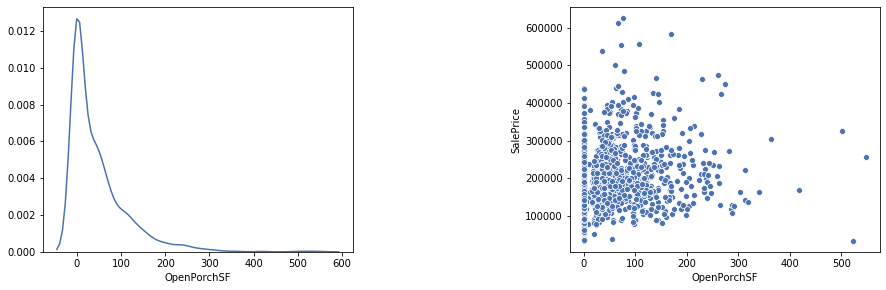

In [65]:
var = 'OpenPorchSF'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* The feature has a significant correlation with the SalePrice so we'll bin it and create dummies.

In [66]:
df_cum['OPSF_0'] = (df_cum['OpenPorchSF'] == 0).astype(int)
df_cum['OpenPorchSF'] = pd.cut(df_cum['OpenPorchSF'], 5)
df_cum = pd.get_dummies(df_cum, columns=['OpenPorchSF'], prefix=['OPSF'])

###### EnclosedPorch (Enclosed porch area in square feet)

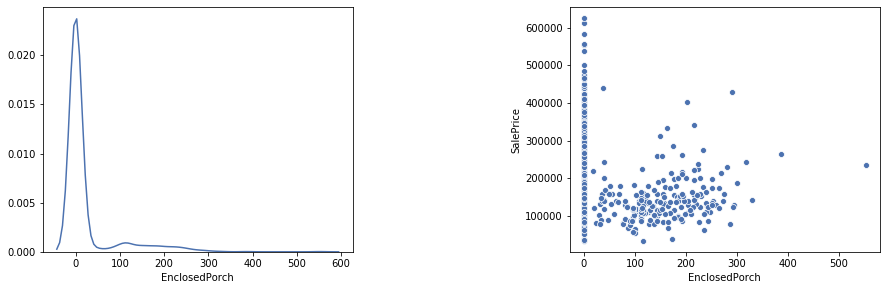

In [67]:
var = 'EnclosedPorch'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

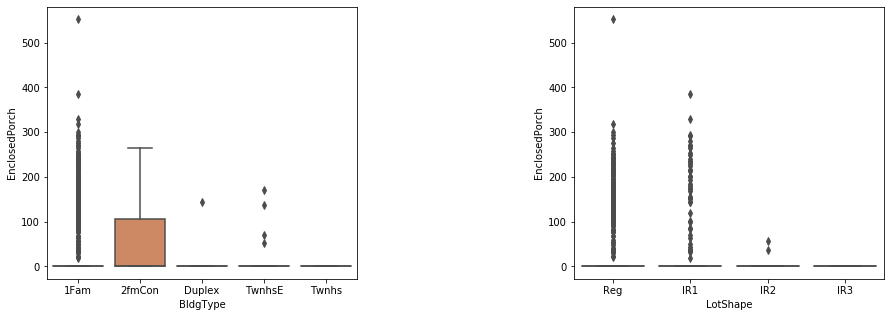

In [68]:
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.7)
sns.boxplot(x='BldgType', y=var, data=df_train, ax=ax[0])
sns.boxplot(x='LotShape', y=var, data=df_train, ax=ax[1])

* This feature has most of its values 0 and doesn't have any correlation with the SalePrice.
* We'll drop it.

In [69]:
df_cum.drop('EnclosedPorch', axis=1, inplace=True)

###### 3SsnPorch (Three season porch area in square feet)

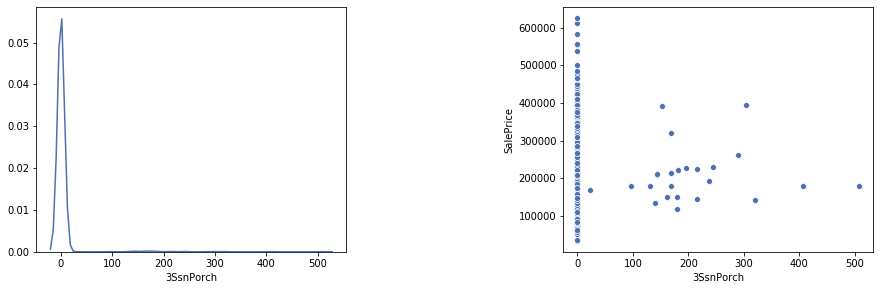

In [70]:
var = '3SsnPorch'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* Same as the above, we'll drop this oner as well.

In [71]:
df_cum.drop('3SsnPorch', axis=1, inplace=True)

###### ScreenPorch (Screen porch area in square feet)

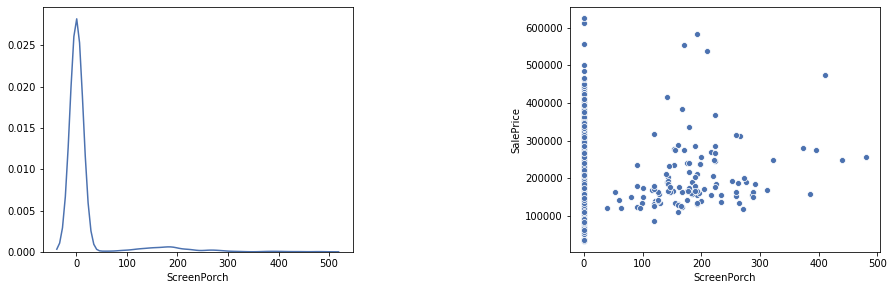

In [72]:
var = 'ScreenPorch'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* Same as the above, we'll drop this one as well.

In [73]:
df_cum.drop('ScreenPorch', axis=1, inplace=True)

###### Fence (Fence quality)

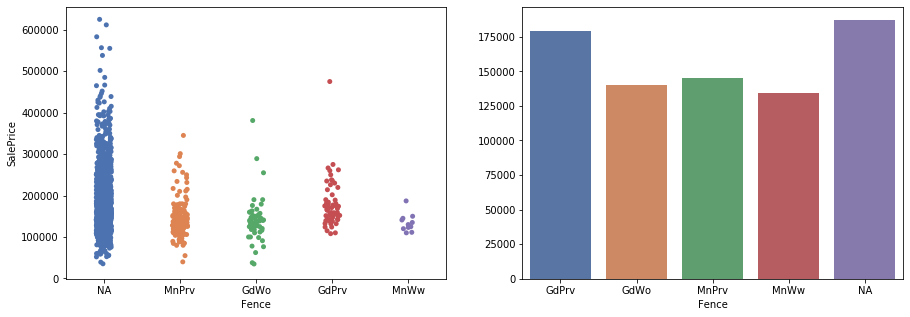

In [74]:
var = 'Fence'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* As expected, houses with good privacy are priced the highest.
* But most of the houses doesn't have any fence.
* We'll create dummy variables

In [75]:
df_cum = pd.get_dummies(df_cum, columns=['Fence'])

##### 2. Foundational features

###### MSSubClass (Identifies the type of dwelling involved in the sale)

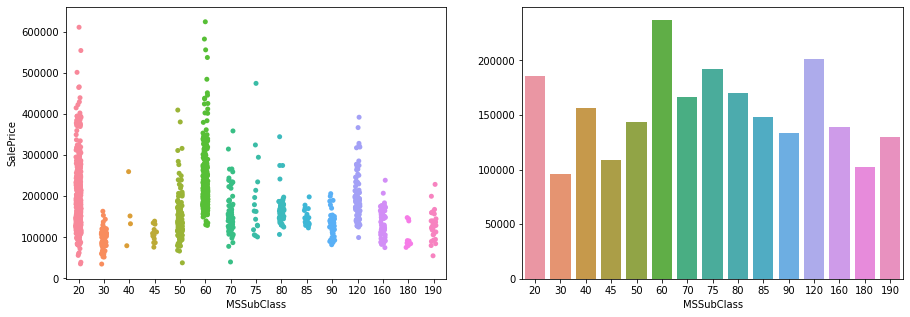

In [76]:
var = 'MSSubClass'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Each integer represents a class of house and hence it should be categorical.
* We'll create a dummy variable for each class.

In [77]:
df_cum = pd.get_dummies(df_cum, columns=['MSSubClass'])

###### MSZoning (Identifies the general zoning classification of the sale)

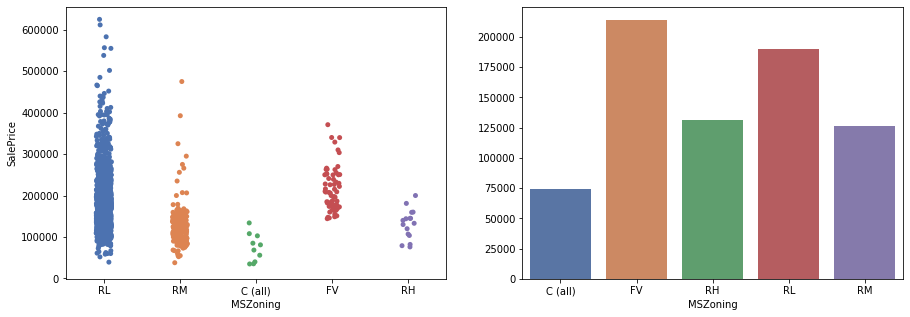

In [78]:
var = 'MSZoning'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Houses in the commercial zones have the least price.
* Houses with residential zones but less density are highly priced. Since this is an expected behaviour, we'll create dummy variables.

In [79]:
df_cum = pd.get_dummies(df_cum, columns=['MSZoning'])

###### LotShape (General shape of property)

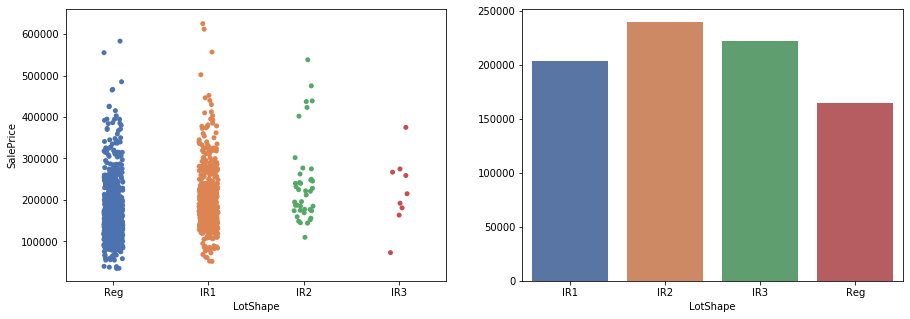

In [80]:
var = 'LotShape'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* The behaviour is not as expected. All the classes have some extreme values.
* Since the categories are not in order, we'll create dummy variables.

In [81]:
df_cum = pd.get_dummies(df_cum, columns=['LotShape'])

###### LandContour (Flatness of the property)

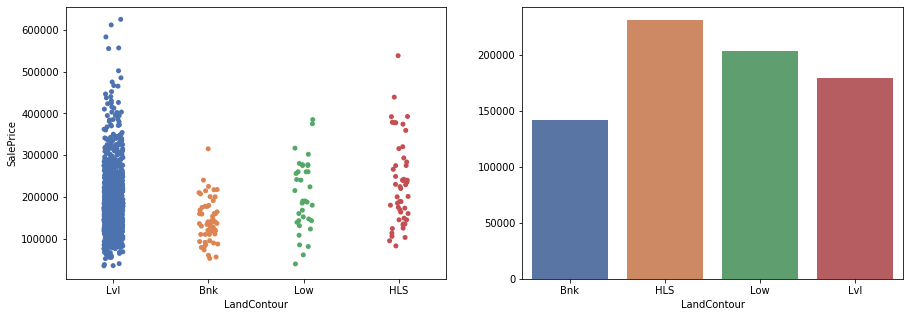

In [82]:
var = 'LandContour'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We'll create dummy variables,

In [83]:
df_cum = pd.get_dummies(df_cum, columns=['LandContour'])

###### LotConfig: Lot configuration

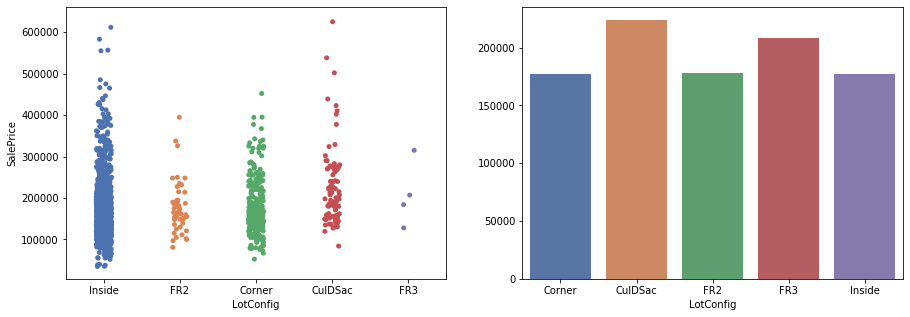

In [84]:
var = 'LotConfig'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We'll create dummy variables

In [85]:
df_cum = pd.get_dummies(df_cum, columns=['LotConfig'])

###### LandSlope (Slope of property)

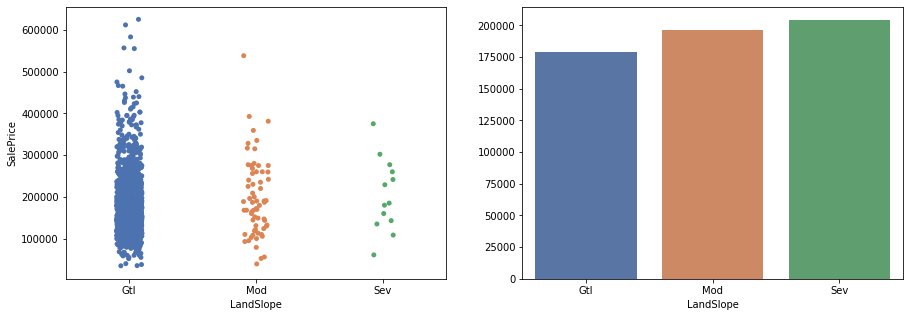

In [86]:
var = 'LandSlope'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We can see that almost all the houses have gentle slope and mod and sev slope doesn't have much difference in detemining the SalePrice.
* We'll create a flag to depict whether therer is gentle slope or not.

In [87]:
df_cum['Gtl_Slope'] = (df_cum['LandSlope'] == 'Gtl')
df_cum.drop('LandSlope', axis=1, inplace=True)

###### BldgType (Type of dwelling)

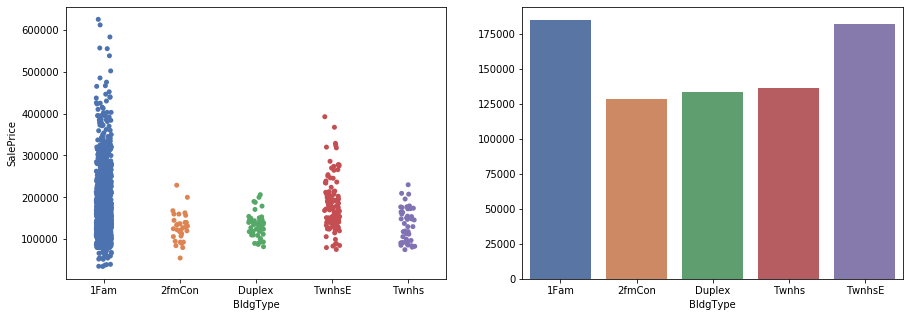

In [88]:
var = 'BldgType'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* 2fmCon, Duplex and Twnhs have very similar distrubution and could be clubbed together.
* But we'll create dummy for each of them to not miss out on any info.

In [89]:
df_cum = pd.get_dummies(df_cum, columns=['BldgType'])

###### HouseStyle (Style of dwelling)

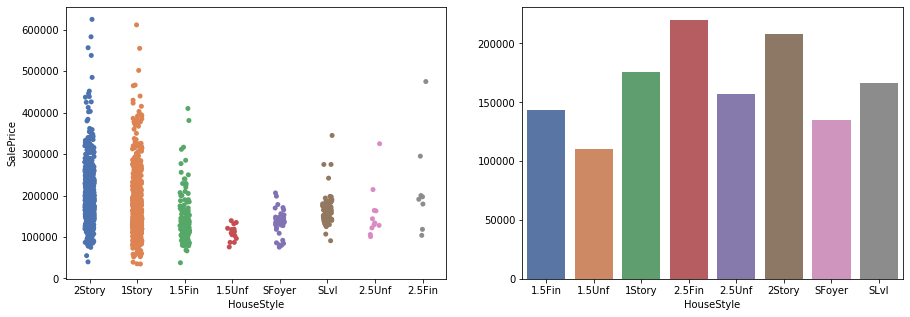

In [90]:
var = 'HouseStyle'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We'll create dummy variables

In [91]:
df_cum = pd.get_dummies(df_cum, columns=[var])

###### RoofStyle (Type of roof)

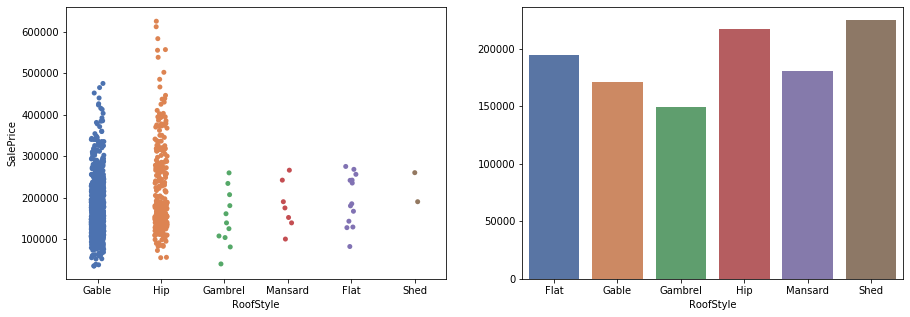

In [92]:
var = 'RoofStyle'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Again, the less frequent categories could be clubbed but let's create dummies for each one of them.

In [93]:
df_cum = pd.get_dummies(df_cum, columns=[var])

###### Foundation (Type of foundation)

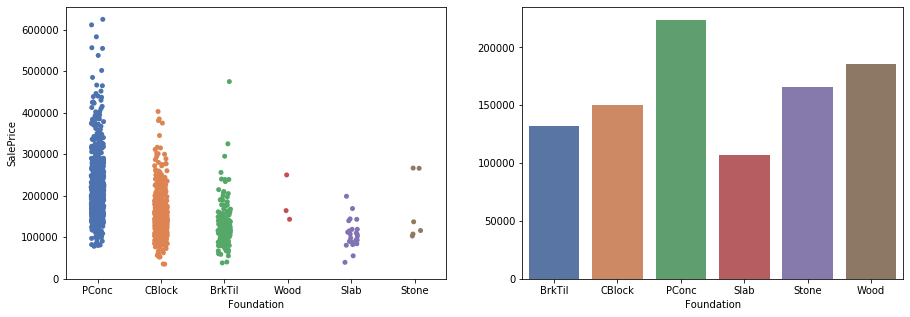

In [94]:
var = 'Foundation'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We'll create dummies

In [95]:
df_cum = pd.get_dummies(df_cum, columns=[var])

##### 3. Interior

###### BsmtQual: Evaluates the height of the basement

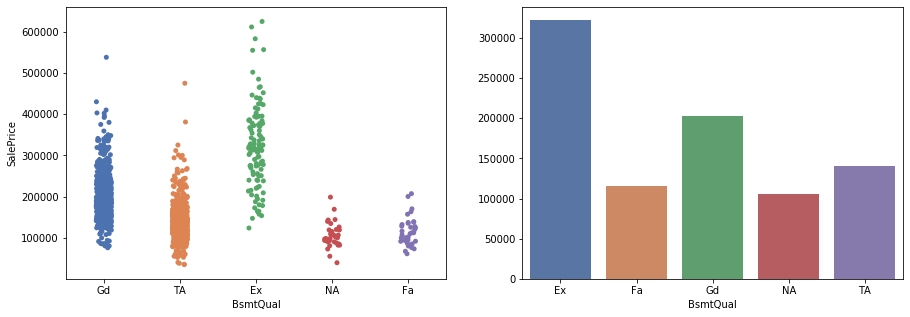

In [96]:
var = 'BsmtQual'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

In [97]:
df_cum[var] = df_cum[var].map({'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'NA':0})

###### BsmtCond: Evaluates the general condition of the basement

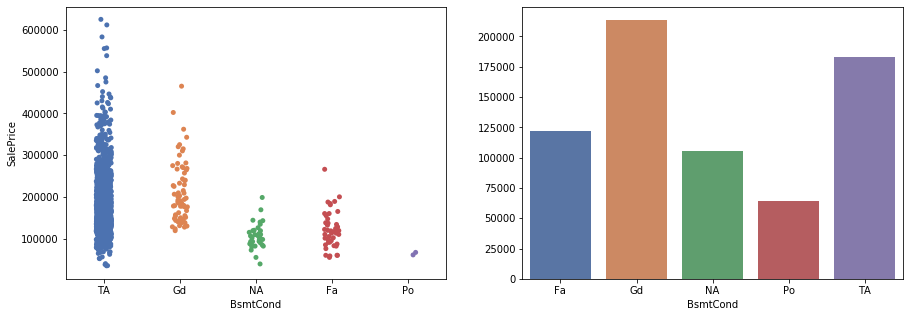

In [98]:
var = 'BsmtCond'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Since quite a lot of TA has higher price than Gd, we'll create dummies not in order.

In [99]:
df_cum = pd.get_dummies(df_cum, columns=[var])

###### BsmtExposure: Refers to walkout or garden level walls

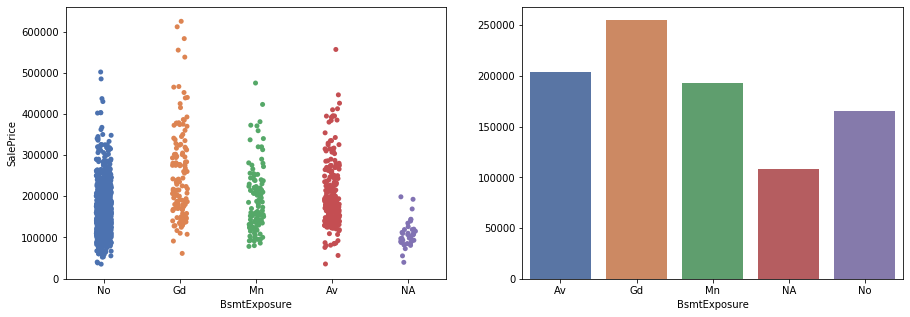

In [100]:
var = 'BsmtExposure'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Seems to me that 'Av', 'Mn' and 'No' could be clubbed together since they have similar distributions.
* We'll create mark them as ordered.

In [101]:
df_cum[var] = df_cum[var].map({'Gd':2, 'Mn':1, 'Av':1, 'No':1, 'NA':0})

###### BsmtFinType1: Rating of basement finished area and BsmtFinType2: Rating of basement finished area (if multiple types)

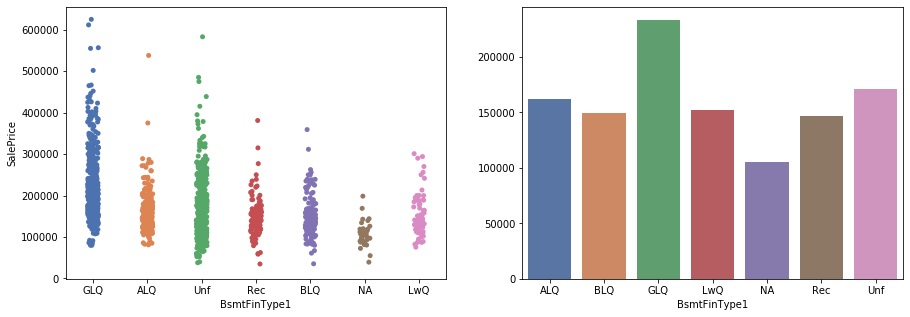

In [102]:
var = 'BsmtFinType1'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

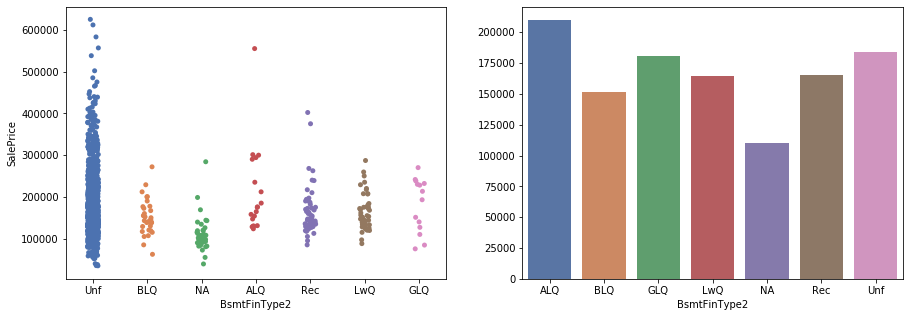

In [103]:
var = 'BsmtFinType2'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Unfinished accounts for a large number of observations in both the types.
* Apart from 'GLQ' and 'ALQ', all the other categories show the same average price in both the basement types.
* Since the sale price is not dependent on the order and both the distributions are not same, we'll create dummy features for both the types.

In [104]:
df_cum = pd.get_dummies(df_cum, columns=['BsmtFinType1'])
df_cum = pd.get_dummies(df_cum, columns=['BsmtFinType2'])

###### BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF 

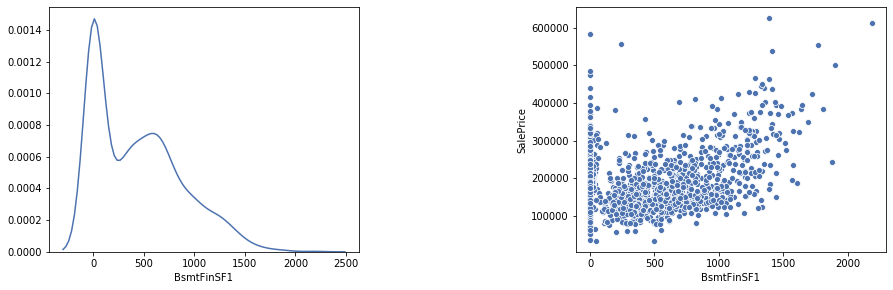

In [105]:
var = 'BsmtFinSF1'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

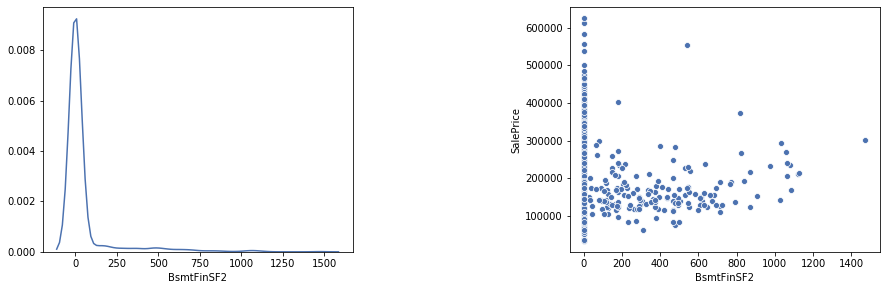

In [106]:
var = 'BsmtFinSF2'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

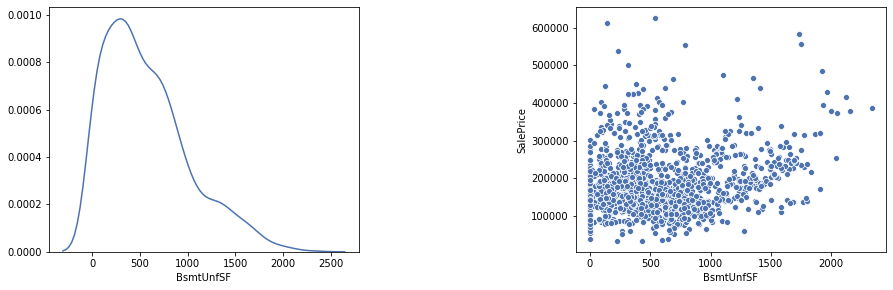

In [107]:
var = 'BsmtUnfSF'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

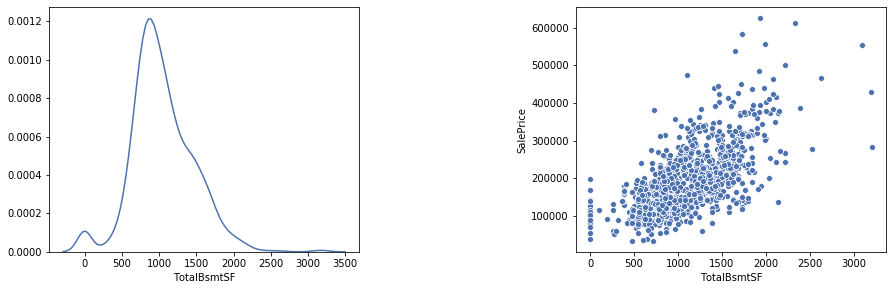

In [108]:
var = 'TotalBsmtSF'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* Looking at the distributions we can easily conclude that TotalBsmtSF is the most important of them all due to high correlation with the SalePrice. We'll apply log transformation for this feature to rectify the distribution.
* BsmtUnfSF also has some correlation with the price and we'll do the same to it as well.
* BsmtFinSF2 has no correlation and most of the values are 0. So we'll replace it with a flag.
* BsmtFinSF1 also has a significant correlation. We'll do log transformation.

In [109]:
df_cum['TotalBsmtSF'] = np.log(df_cum['TotalBsmtSF'] + 1)
df_cum['BsmtUnfSF'] = np.log(df_cum['BsmtUnfSF'] + 1)
df_cum.drop('BsmtFinSF2', axis=1, inplace=True)
df_cum['BsmtFinSF1'] = np.log(df_cum['BsmtFinSF1'] + 1)

###### 1stFlrSF: First Floor square feet

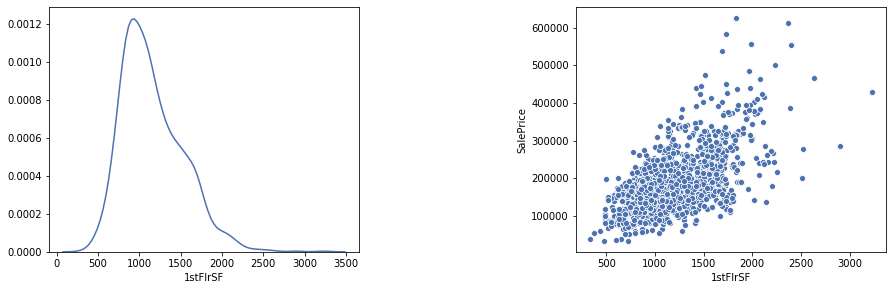

In [110]:
var = '1stFlrSF'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* Clearly this feature has very high correlation and will play an important role in predicting the price.
* We'll do log transformation.

In [111]:
df_cum['1stFlrSF'] = np.log(df_cum['1stFlrSF'])

###### 2ndFlrSF: Second floor square feet

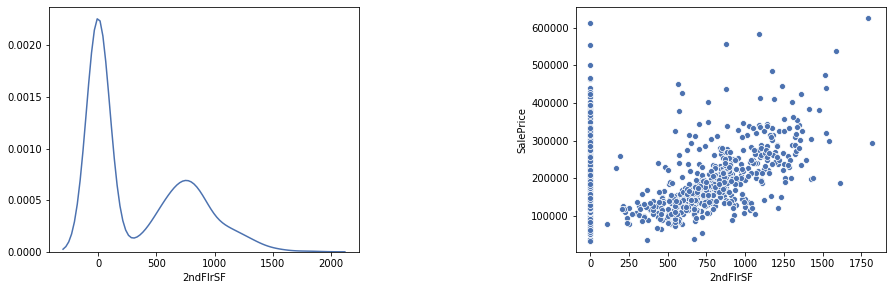

In [112]:
var = '2ndFlrSF'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* This also has a good positive correlation but most of the observations are 0.
* We'll bin the values and add a flag for zeros.

In [113]:
df_cum['2FlrSF_0'] = (df_cum['2ndFlrSF'] == 0).astype(int)
df_cum['2ndFlrSF'] = np.log(df_cum['2ndFlrSF'] + 1)

In [114]:
# df_cum['2FlrSF_0'] = (df_cum['2ndFlrSF'] == 0).astype(int)
# df_cum['2ndFlrSF'] = pd.cut(df_cum['2ndFlrSF'], 5)
# df_cum = pd.get_dummies(df_cum, columns=['2ndFlrSF'], prefix=['2ndFlr'])

###### LowQualFinSF: Low quality finished square feet (all floors)

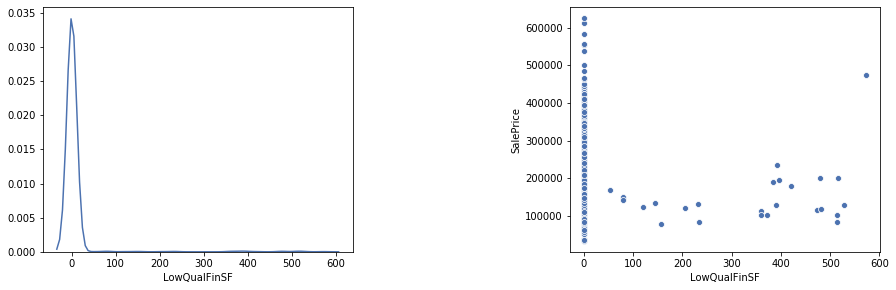

In [115]:
var = 'LowQualFinSF'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* This doesn't seem to be of any use. We'll drop it.

In [116]:
df_cum.drop(var, axis=1, inplace=True)

###### GrLivArea: Above grade (ground) living area square feet

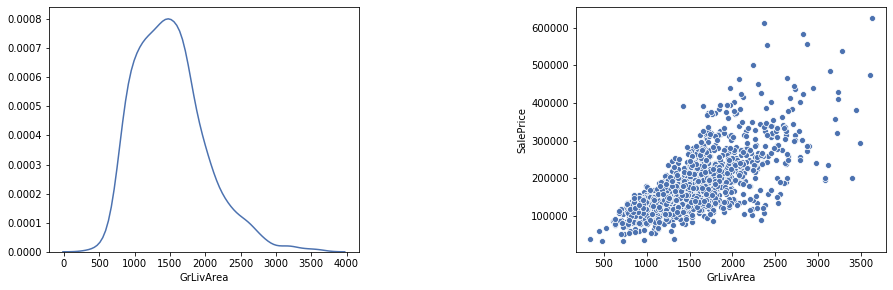

In [117]:
var = 'GrLivArea'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

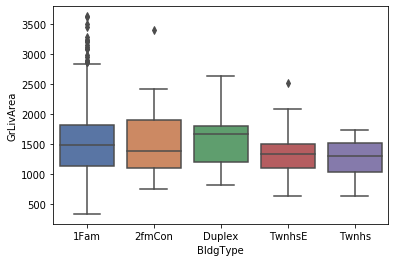

In [118]:
sns.boxplot(x='BldgType', y='GrLivArea', data=df_train)

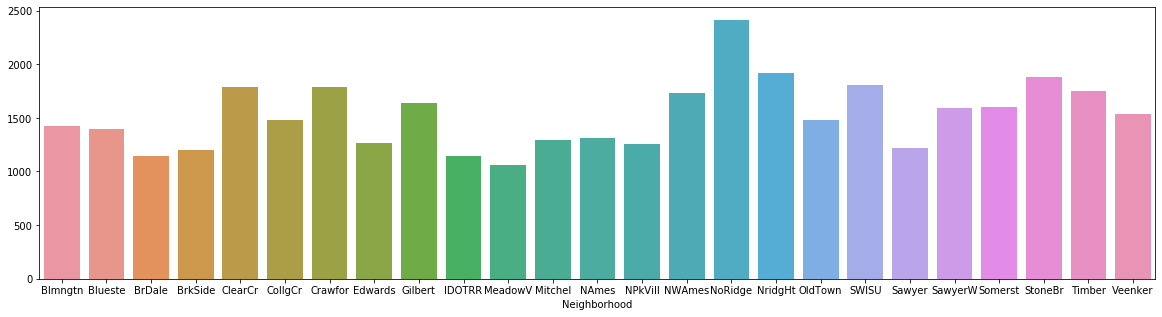

In [119]:
plt.figure(figsize=(20, 5))
var = 'Neighborhood'
mean = df_train.groupby(var).mean()['GrLivArea']
sns.barplot(x=mean.keys(), y=mean.to_numpy())

* This is surely an important feature due to its correlation with the SalePrice.
* The average area depends upon the factors such as neighborhood and building type as well.
* We'll take a log transform to rectify the distribution.

In [120]:
df_cum['GrLivArea'] = np.log(df_cum['GrLivArea'])

###### BsmtFullBath: Basement full bathrooms and BsmtHalfBath: Basement half bathrooms

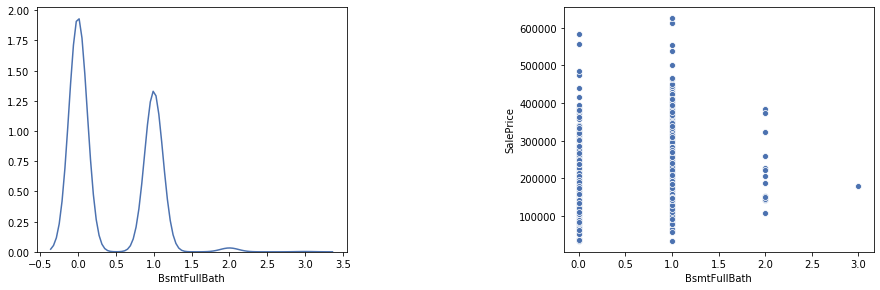

In [121]:
var = 'BsmtFullBath'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

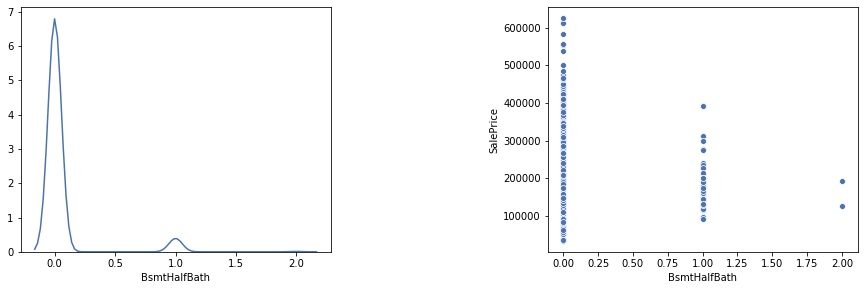

In [122]:
var = 'BsmtHalfBath'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* For both the features, sale price doesn't increase as the no of baths do.
* As they are not ordered, we'll create dummy variables.

In [123]:
df_cum = pd.get_dummies(df_cum, columns=['BsmtFullBath'])
df_cum = pd.get_dummies(df_cum, columns=['BsmtHalfBath'])

###### FullBath: Full bathrooms above grade

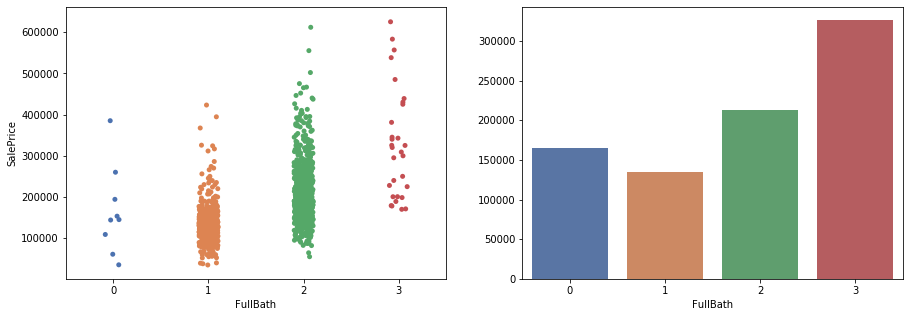

In [124]:
var = 'FullBath'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

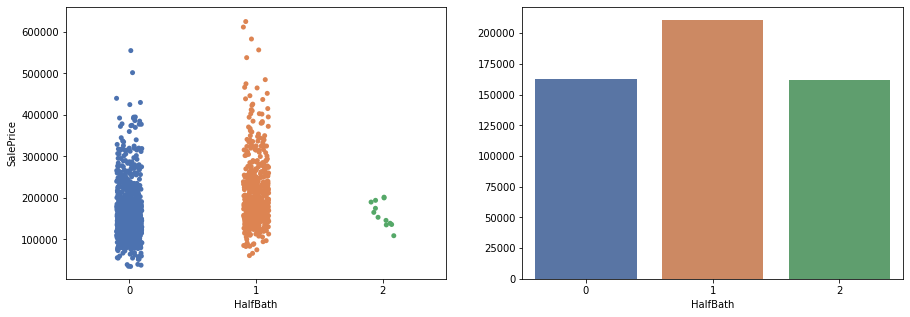

In [125]:
var = 'HalfBath'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* FullBath has a high correlation with the SalePrice so we'll let it be.
* HalfBath doesn't seem to be ordered so we'll create dummy variables.

In [126]:
df_cum = pd.get_dummies(df_cum, columns=['HalfBath'])

###### Bedroom: Bedrooms above grade (does NOT include basement bedrooms)

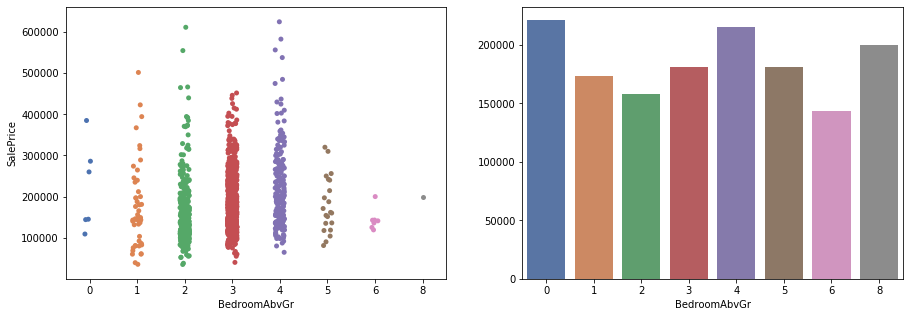

In [127]:
var = 'BedroomAbvGr'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Since this in not an ordinal feauture, we'll create dummy variables

In [128]:
df_cum = pd.get_dummies(df_cum, columns=[var])

###### Kitchen: Kitchens above grade

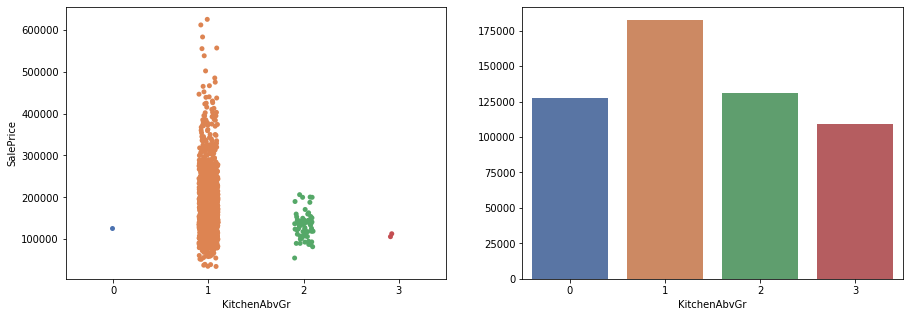

In [129]:
var = 'KitchenAbvGr'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Since it is an ordinal feature, with price reducing as the no increases, we'll leave the feature as it is.

###### KitchenQual: Kitchen quality

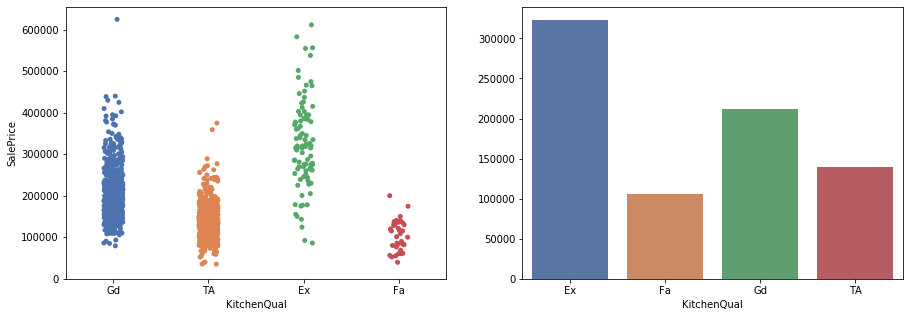

In [130]:
var = 'KitchenQual'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We'll create an ordered feature.

In [131]:
df_cum[var] = df_cum[var].map({'Ex':4, 'Gd':3, 'TA':2, 'Fa':1})

###### TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

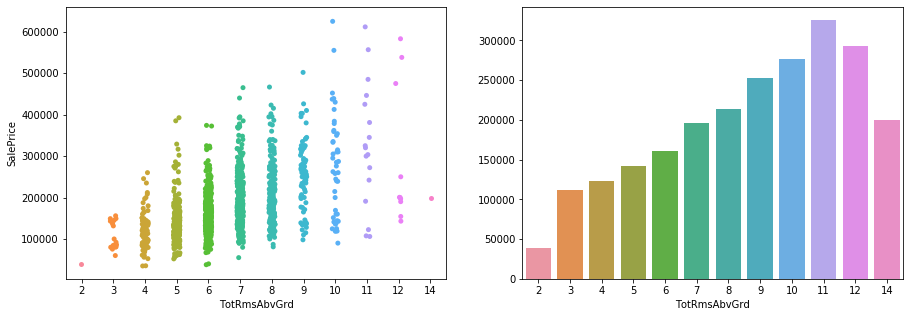

In [132]:
var = 'TotRmsAbvGrd'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Since the trend is increasing SP with no of rooms, we'll leave it as it is.

###### GarageType: Garage location

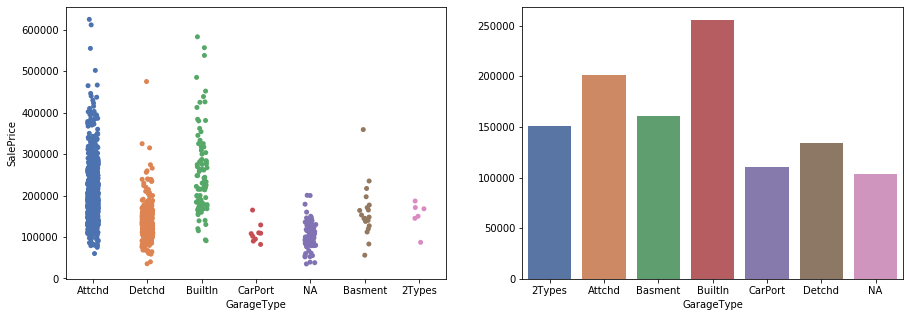

In [133]:
var = 'GarageType'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We'll create dummy variables.

In [134]:
df_cum = pd.get_dummies(df_cum, columns=['GarageType'])

###### GarageYrBlt: Year garage was built

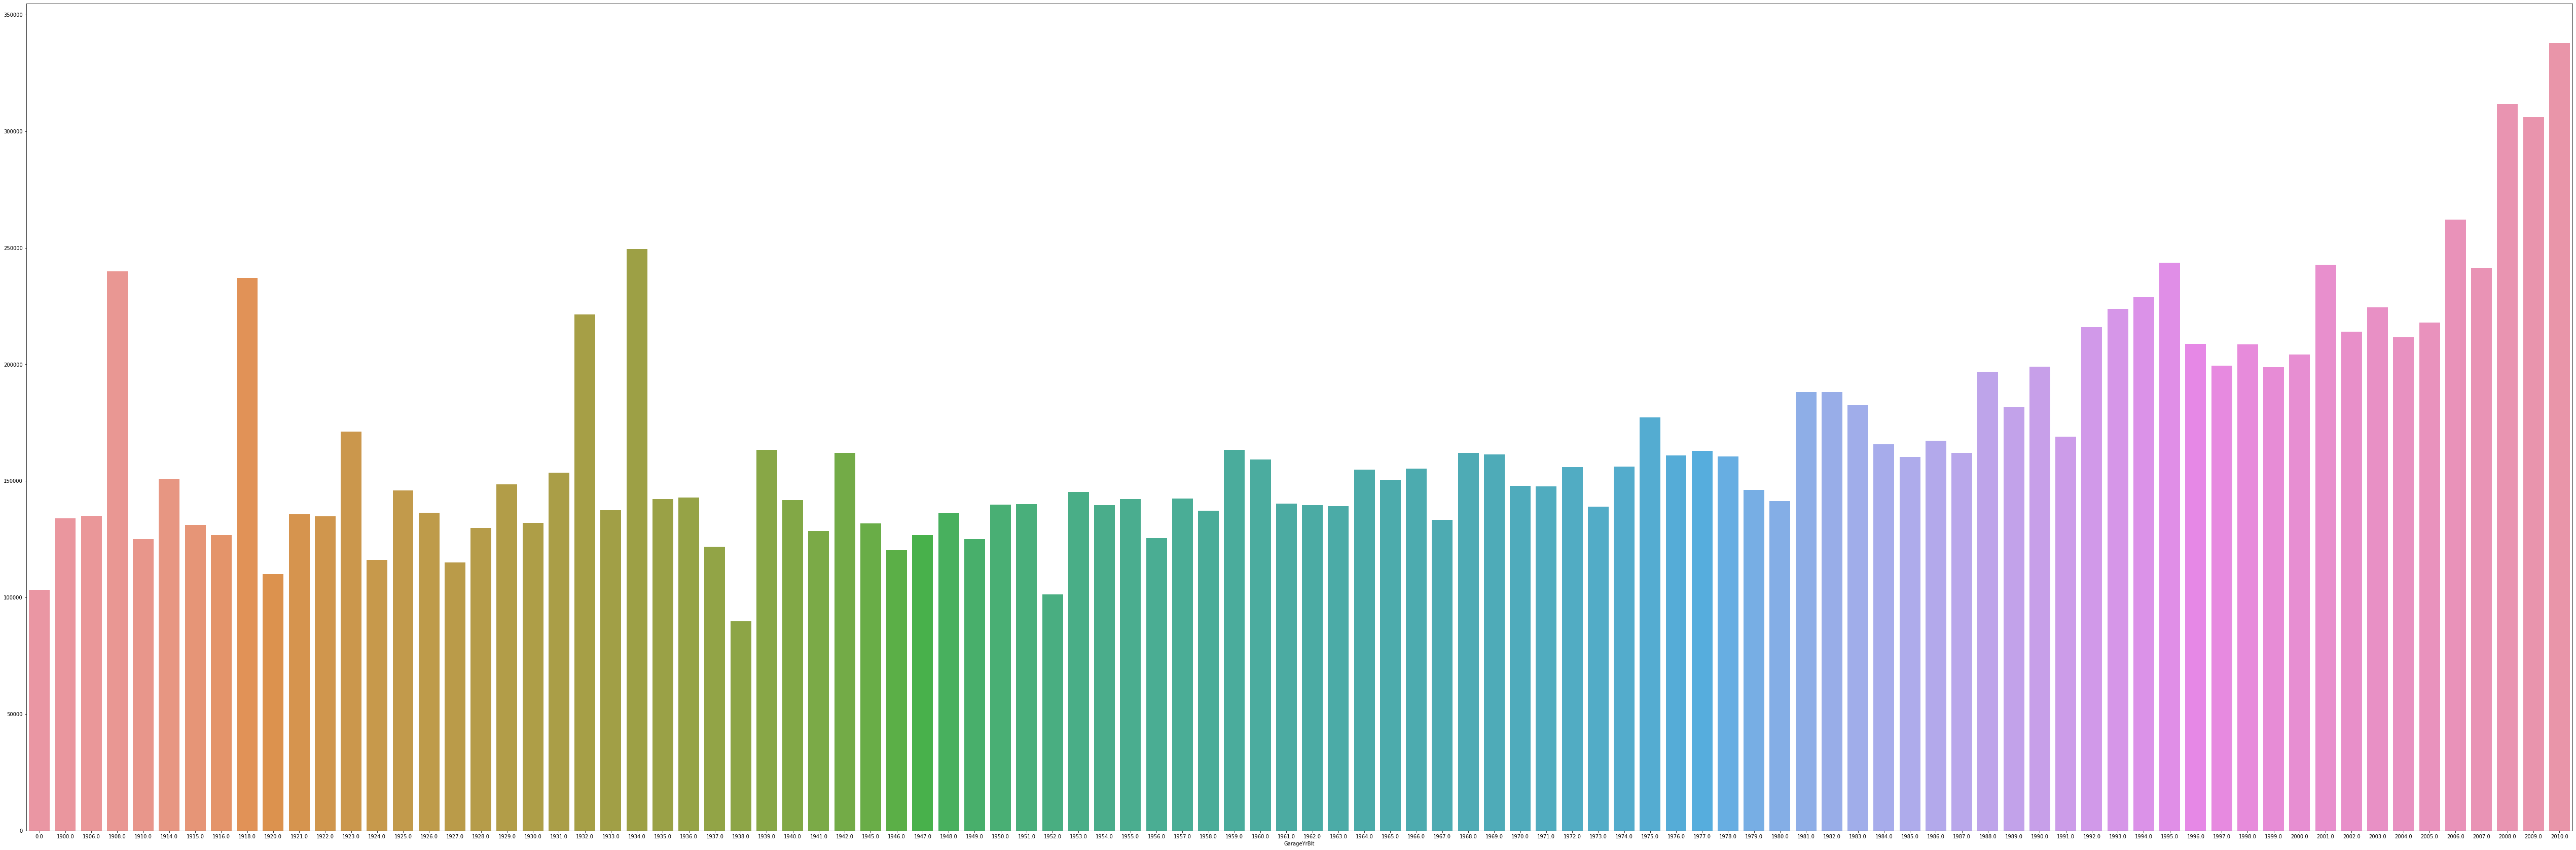

In [135]:
var = 'GarageYrBlt'
plt.figure(figsize=(90, 30))
mean = df_train.groupby(var).mean()['SalePrice']
sns.barplot(x=mean.keys(), y=mean.to_numpy())

* We can observe that newer the garage, higher is the sale price in general.
* Even though it is a continous feature, it should be represented categorically.
* We'll create bins and assign a dummy variable for each group.

In [136]:
df_cum['GarageYrBlt'] = pd.cut(df_cum['GarageYrBlt'], 8)
df_cum = pd.get_dummies(df_cum, columns=['GarageYrBlt'], prefix=['GrgYr'])

###### GarageFinish: Interior finish of the garage

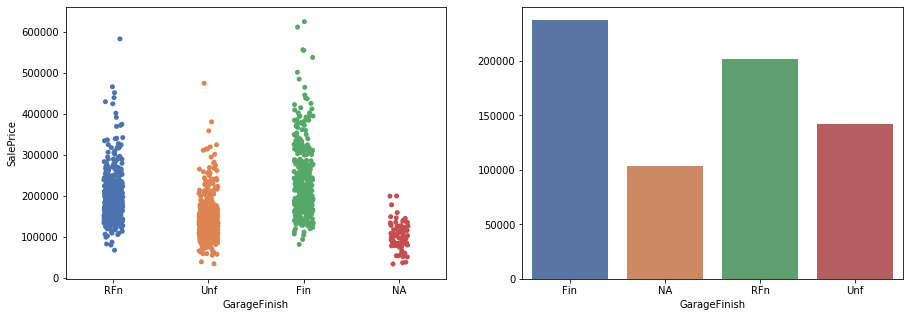

In [137]:
var = 'GarageFinish'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Since this is an ordered feature, we'll replace them with numbers

In [138]:
df_cum[var] = df_cum[var].map({'Fin':3, 'RFn':2, 'Unf':1, 'NA':0})

###### GarageCars: Size of garage in car capacity

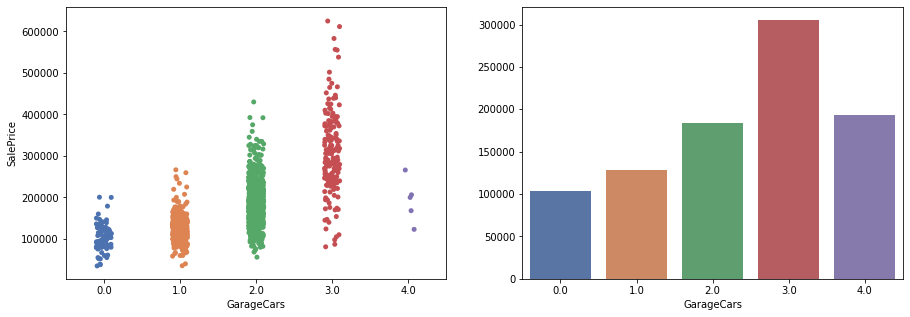

In [139]:
var = 'GarageCars'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Totally correlated with SP and in order except for 4, in which the price decreases as families usually don't own more than 2-3 cars.
* We'll leave it as it is.

###### GarageArea: Size of garage in square feet

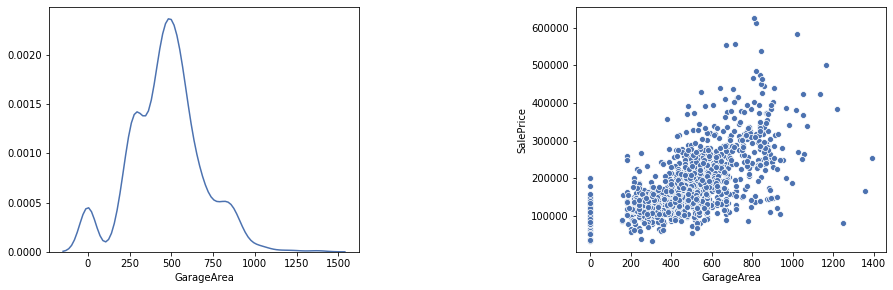

In [140]:
var = 'GarageArea'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* Again, an important feature with high correlation with SP.
* This time let's create bins and then a dummy for each range.

In [141]:
df_cum['GrgAr_0'] = (df_cum['GarageArea'] == 0).astype('int')
df_cum['GarageArea'] = np.log(df_cum['GarageArea'] + 1)

In [142]:
# df_cum['GrgAr_0'] = (df_cum['GarageArea'] == 0).astype('int')
# df_cum['GarageArea'] = pd.cut(df_cum['GarageArea'], 5)
# df_cum = pd.get_dummies(df_cum, columns=['GarageArea'], prefix=['GrgAr'])

###### GarageQual: Garage quality

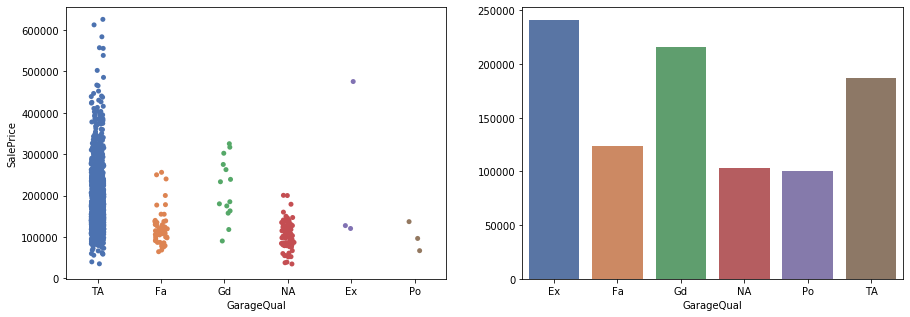

In [143]:
var = 'GarageQual'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Almost all the houses have either Average quality or no garage (NA).
* NA is already represented in other garage features.
* We can drop this feature and replace it with a flag representing whether TA is present or not.

In [144]:
df_cum['GrgQual_TA'] = (df_cum['GarageQual'] == 'TA').astype(int)
df_cum.drop('GarageQual', axis=1, inplace=True)

###### GarageCond: Garage condition

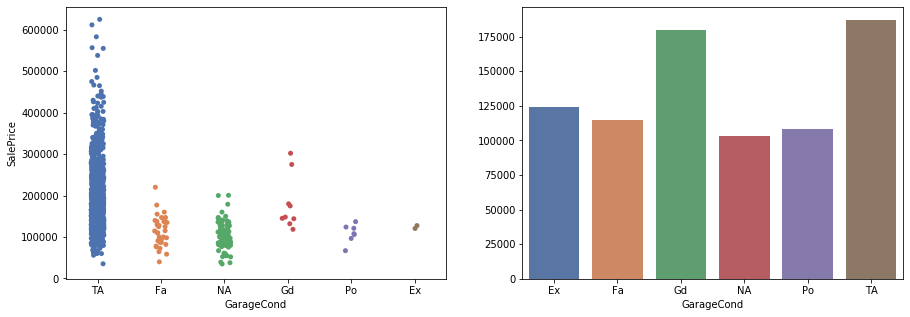

In [145]:
var = 'GarageCond'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Same as above, we can drop this feature.

In [146]:
df_cum.drop('GarageCond', axis=1, inplace=True)

##### 4. Utilities

###### Heating: Type of heating

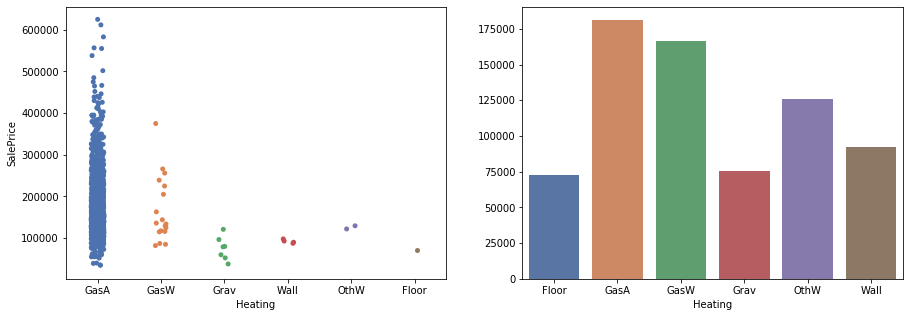

In [147]:
var = 'Heating'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Most of the houses have GasA, so we can replace this feature with a flag.

In [148]:
df_cum['Heat_GasA'] = (df_cum['Heating'] == 'GasA').astype(int)
df_cum.drop('Heating', axis=1, inplace=True)

###### HeatingQC: Heating quality and condition

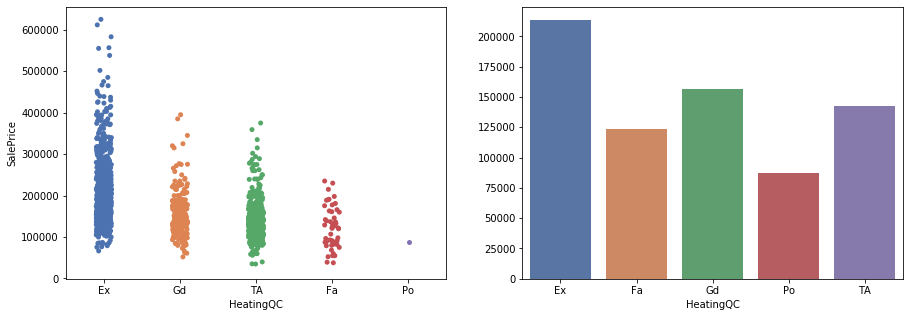

In [149]:
var = 'HeatingQC'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* This is clearly an ordinal feature.
* We'll replace the categories with numbers.

In [150]:
df_cum['HeatingQC'] = df_cum['HeatingQC'].map({'Ex':4, 'Gd':3, 'TA':2, 'Fa':1, 'Po':0})

###### CentralAir: Central air conditioning

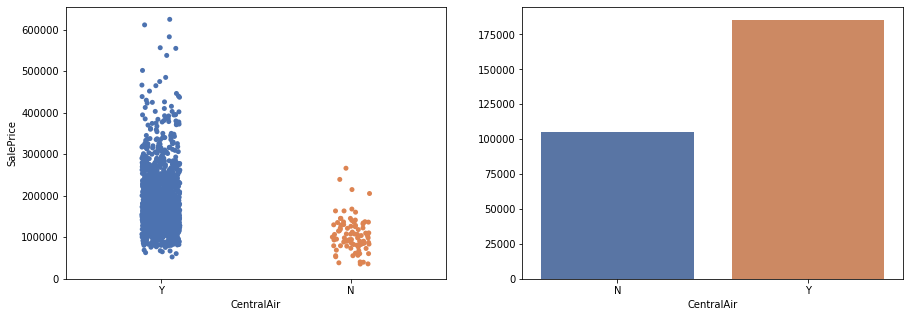

In [151]:
var = 'CentralAir'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Will create a flag

In [152]:
df_cum[var] = (df_cum[var] == 'Y').astype(int)

###### Electrical: Electrical system

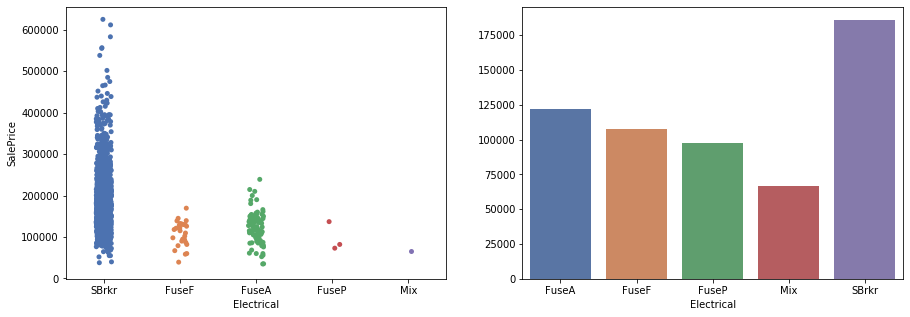

In [153]:
var = 'Electrical'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Seems like an ordered feature. Will map to integers.

In [154]:
df_cum[var] = df_cum[var].map({'SBrkr':4, 'FuseA':3, 'FuseF':2, 'FuseP':1, 'Mix':0})

###### Fireplaces: Number of fireplaces

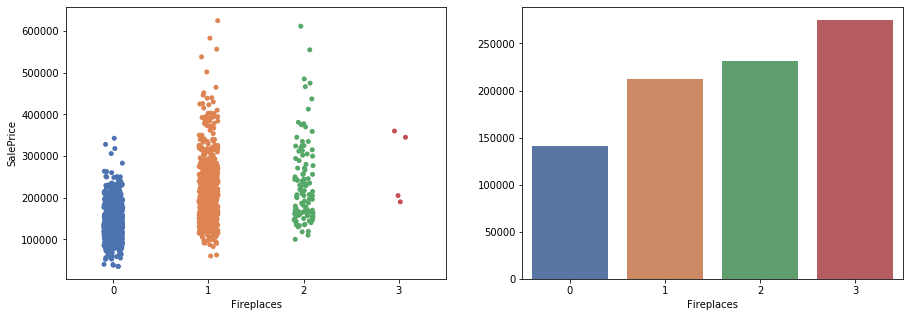

In [155]:
var = 'Fireplaces'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We'll leave it as it is since it is ordered.

###### FireplaceQu: Fireplace quality

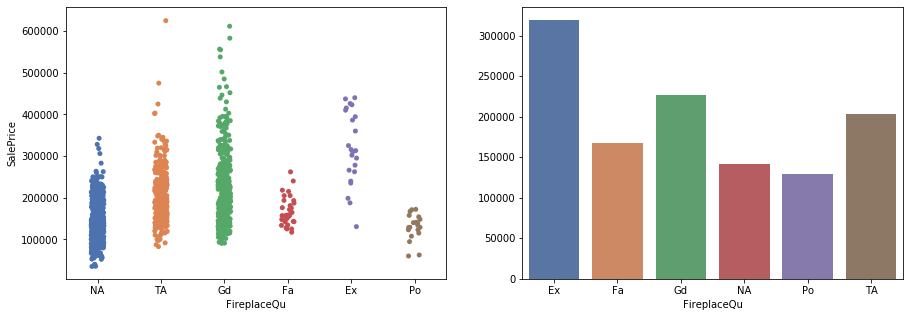

In [156]:
var = 'FireplaceQu'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Categorial feature in order. Will map to integers.

In [157]:
df_cum[var] = df_cum[var].map({'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0})

###### PoolArea: Pool area in square feet

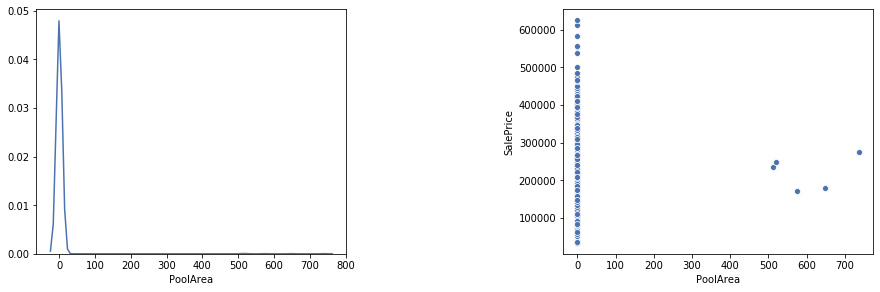

In [158]:
var = 'PoolArea'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* Almost all values are 0.
* We'll drop this feature.

In [159]:
df_cum.drop('PoolArea', axis=1, inplace=True)

###### PoolQC: Pool quality

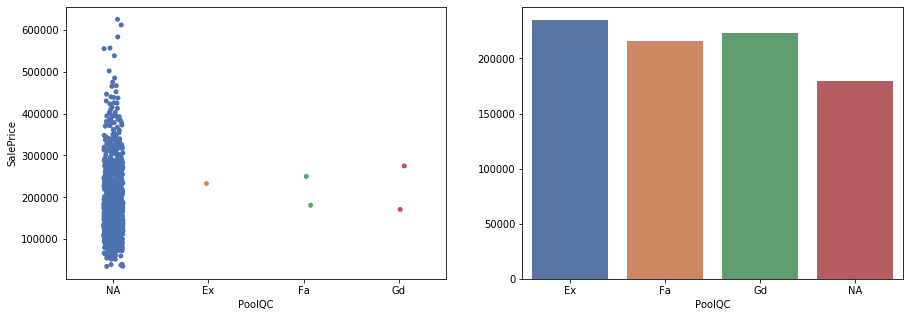

In [160]:
var = 'PoolQC'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Drop it.

In [161]:
df_cum.drop('PoolQC', axis=1, inplace=True)

##### 5. Misc

###### OverallQual: Rates the overall material and finish of the house

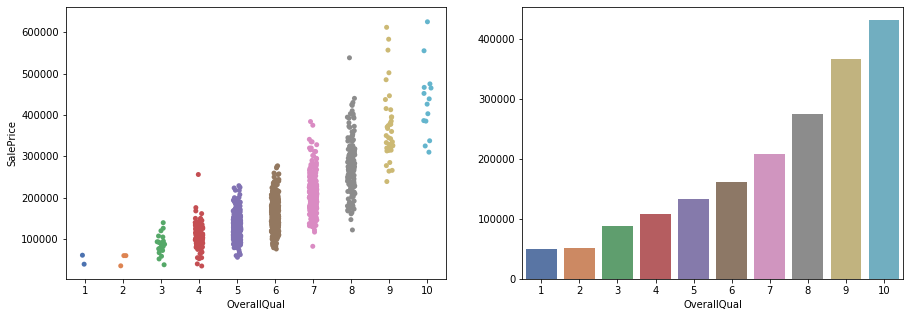

In [162]:
var = 'OverallQual'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Very important feature.
* Will leave it as it is.

###### OverallCond: Rates the overall condition of the house

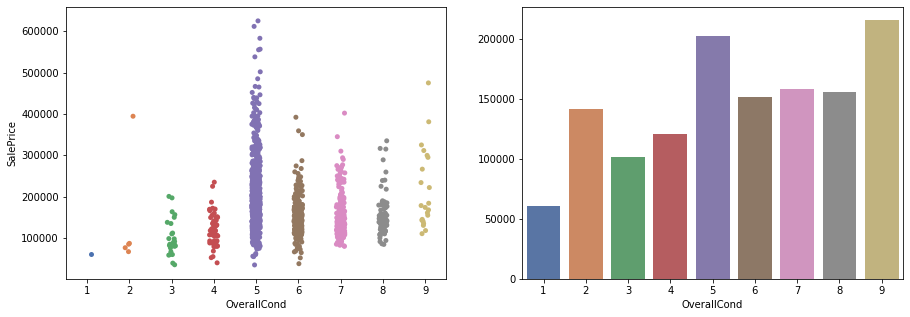

In [163]:
var = 'OverallCond'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Very unexpected behaviour where 5 has the peak in SP instead of 9.
* Apart from this abberation, else is as expected. (2 has a spike because of only one observation).
* We'll leave as it is.

###### YearBuilt: Original construction date

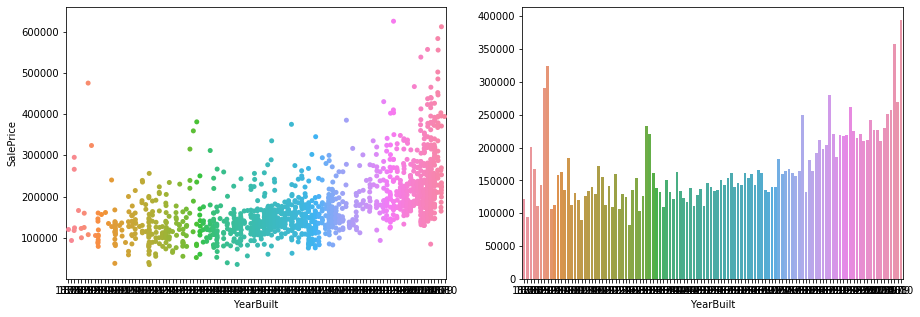

In [164]:
var = 'YearBuilt'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* SP is increasing with year, high correlation.
* We'll create bins and add dummy for each range.

In [165]:
df_cum[var] = pd.cut(df_cum[var], 8)
df_cum = pd.get_dummies(df_cum, columns=[var], prefix=['YrBlt'])

###### YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

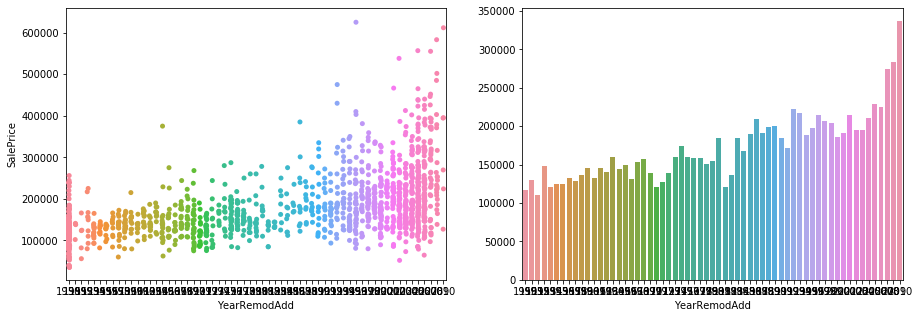

In [166]:
var = 'YearRemodAdd'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Again, SP seems to increase with year.
* We'll create bins and dummy.

In [167]:
df_cum[var] = pd.cut(df_cum[var], 8)
df_cum = pd.get_dummies(df_cum, columns=[var], prefix=['YrRmod'])

###### Functional: Home functionality (Assume typical unless deductions are warranted)

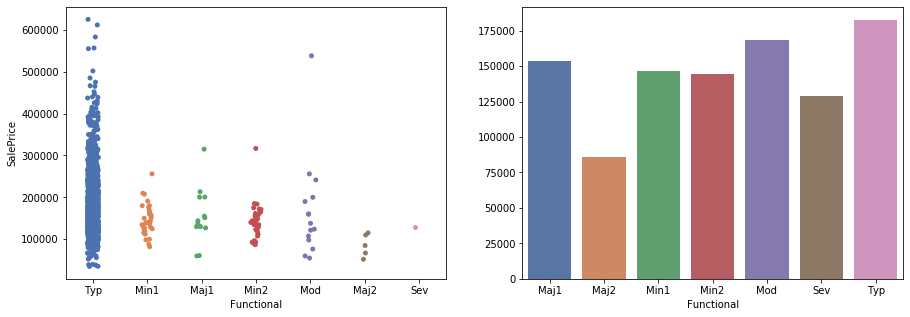

In [168]:
var = 'Functional'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Since this doesn't seem to be ordered, we'll create dummy variables

In [169]:
df_cum = pd.get_dummies(df_cum, columns=[var])

###### MiscFeature: Miscellaneous feature not covered in other categories

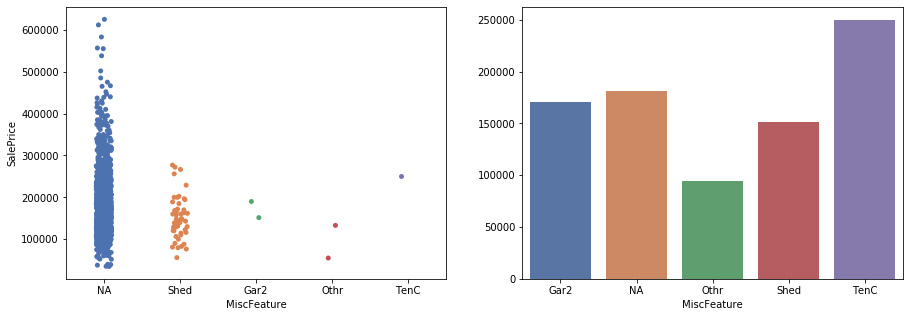

In [170]:
var = 'MiscFeature'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Since the frequency of observations in NA is toot high, we'll create a flag of whether any Misc feature is present.

In [171]:
df_cum['MiscFeatPr'] = (df_cum['MiscFeature'] != 'NA').astype(int)
df_cum.drop(var, axis=1, inplace=True)

###### MiscVal: Value of miscellaneous feature

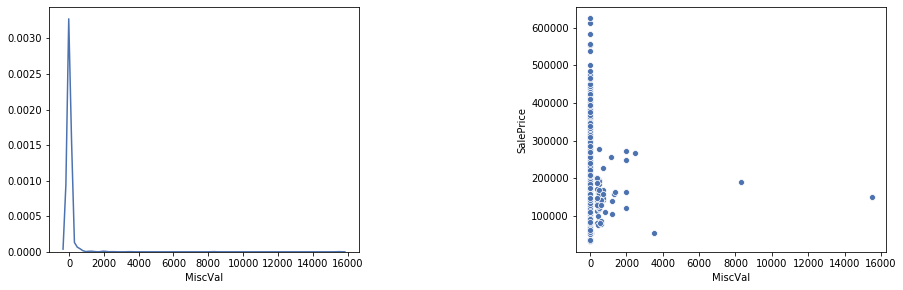

In [172]:
var = 'MiscVal'
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,4.5))
plt.subplots_adjust(wspace=0.7)
sns.distplot(df_train[var], hist = False, kde = True, ax=ax[0])
sns.scatterplot(y="SalePrice", x=var, data=df_train, ax=ax[1])

* Quite a lot of observations are 0.
* We'll create a flag.

In [173]:
df_cum['MiscVal_0'] = (df_cum['MiscVal'] == 0).astype(int)
df_cum.drop(var, axis=1, inplace=True)

###### MoSold: Month Sold (MM)

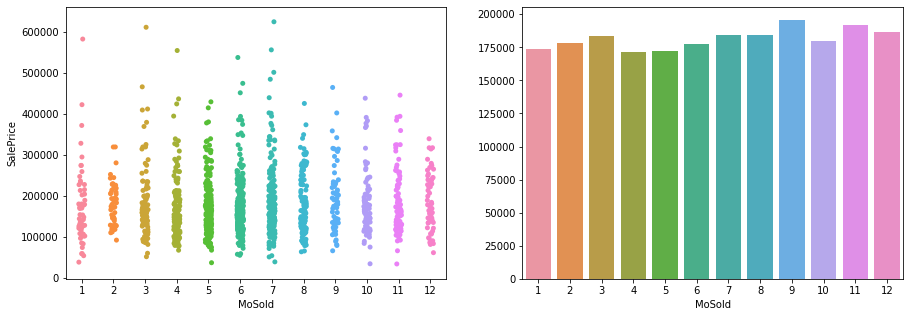

In [174]:
var = 'MoSold'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Month + year should give some info about the SP.
* We'll create dummy variables.

In [175]:
df_cum = pd.get_dummies(df_cum, columns=[var])

###### YrSold: Year Sold (YYYY)

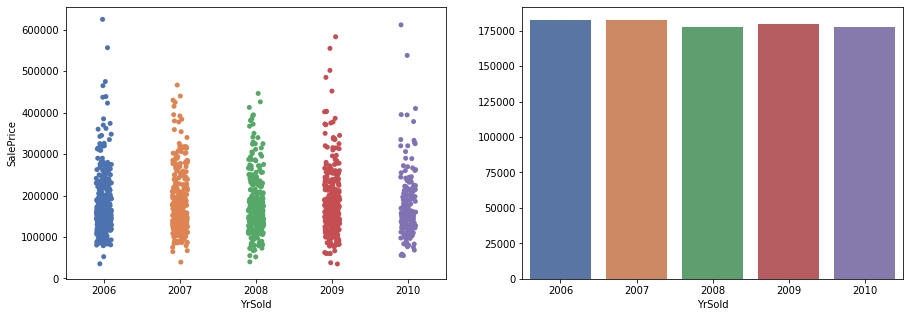

In [176]:
var = 'YrSold'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* We'll create dummy variables.

In [177]:
df_cum = pd.get_dummies(df_cum, columns=[var])

###### SaleType: Type of sale

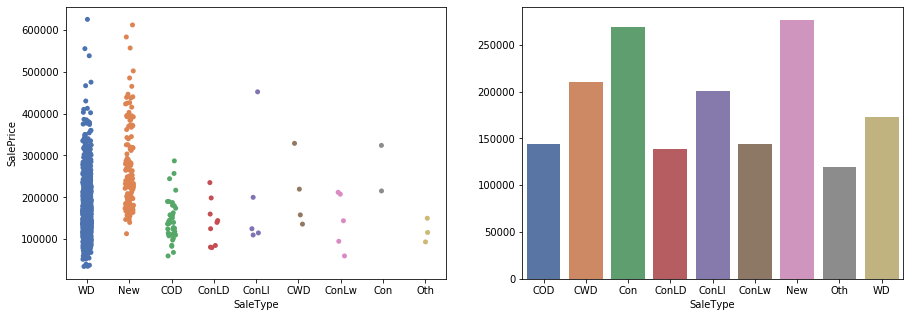

In [178]:
var = 'SaleType'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Dummy variables.

In [179]:
df_cum = pd.get_dummies(df_cum, columns=[var])

###### SaleCondition: Condition of sale

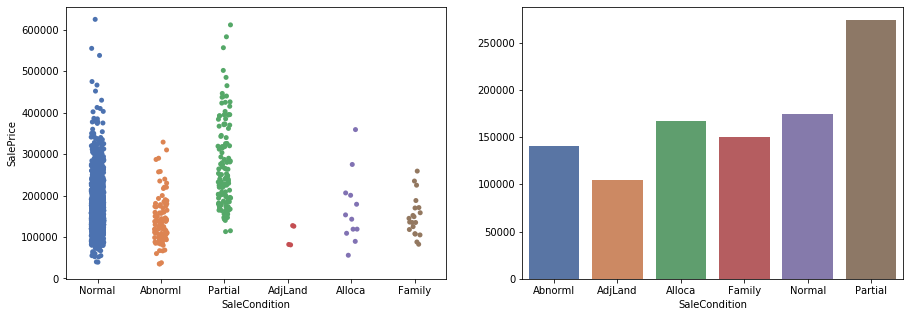

In [180]:
var = 'SaleCondition'
mean = df_train.groupby(var).mean()['SalePrice']
fig, ax =plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.subplots_adjust(wspace=0.2)
sns.stripplot(x=var, y='SalePrice', data=df_train, ax=ax[0])
sns.barplot(x=mean.keys(), y=mean.to_numpy(), ax=ax[1])

* Dummy variables

In [181]:
df_cum = pd.get_dummies(df_cum, columns=[var])

In [182]:
df_cum

LotFrontage   LotArea  OverallQual  OverallCond  MasVnrArea  ExterQual  \
0        4.174387  9.041922            7            5       196.0          3   
1        4.382027  9.169518            6            8         0.0          2   
2        4.219508  9.328123            7            5       162.0          3   
3        4.094345  9.164296            7            5         0.0          2   
4        4.430817  9.565214            8            5       350.0          3   
...           ...       ...          ...          ...         ...        ...   
2910     3.044522  7.568379            4            7         0.0          2   
2911     3.044522  7.546446            4            5         0.0          2   
2912     5.075174  9.903488            5            7         0.0          2   
2913     4.127134  9.253496            5            5         0.0          2   
2914     4.304065  9.172327            7            5        94.0          2   

      BsmtQual  BsmtExposure  BsmtFinSF1  BsmtUnfSF  ...  SaleType_ConLw  \
0            3             1    6.561031   5.017280  ...               0   
1            3             2    6.886532   5.652489  ...               0   
2            3             1    6.188264   6.075346  ...               0   
3            2             1    5.379897   6.293419  ...               0   
4            3             1    6.486161   6.196444  ...               0   
...        ...           ...         ...        ...  ...             ...   
2910         2             1    0.000000   6.304449  ...               0   
2911         2             1    5.533389   5.686975  ...               0   
2912         2             1    7.110696   0.000000  ...               0   
2913         3             1    5.823046   6.356108  ...               0   
2914         3             1    6.632002   5.476464  ...               0   

      SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0                0             0            1                      0   
1                0             0            1                      0   
2                0             0            1                      0   
3                0             0            1                      1   
4                0             0            1                      0   
...            ...           ...          ...                    ...   
2910             0             0            1                      0   
2911             0             0            1                      1   
2912             0             0            1                      1   
2913             0             0            1                      0   
2914             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
2910                      0                     0                     0   
2911                      0                     0                     0   
2912                      0                     0                     0   
2913                      0                     0                     0   
2914                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  
0                        1                      0  
1                        1                      0  
2                        1                      0  
3                        0                      0  
4                        1                      0  
...                    ...                    ...  
29

In [183]:
df_cum.isnull().values.any()

False